In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
import itertools

Using TensorFlow backend.


In [4]:
df = pd.read_csv("drive/app/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [0]:
def save_data(X_train, y_train, fname='', folder='drive/app/'):
    np.save(folder + 'X_train' + fname, X_train)
    np.save(folder + 'y_train' + fname, y_train)

In [7]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [0]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape
save_data(x_train, y_train, fname='_training')

In [0]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])
save_data(x_test, y_test, fname='_public_testing')

In [10]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)
datagen.fit(x_train)

In [12]:
model = Sequential()

model.add(Conv2D(64, 3, input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
__________

Epoch 1/700
288/287 [==============================] - 29s 100ms/step - loss: 1.5984 - acc: 0.3701 - val_loss: 1.5946 - val_acc: 0.3881

Epoch 00001: val_loss improved from inf to 1.59465, saving model to drive/app/face_model.h5
Epoch 2/700
225/287 [======================>.......] - ETA: 5s - loss: 1.5781 - acc: 0.3833

288/287 [==============================] - 29s 101ms/step - loss: 1.5732 - acc: 0.3838 - val_loss: 1.4606 - val_acc: 0.4427

Epoch 00002: val_loss improved from 1.59465 to 1.46062, saving model to drive/app/face_model.h5
Epoch 3/700
288/287 [==============================] - 29s 102ms/step - loss: 1.5515 - acc: 0.3928 - val_loss: 1.4109 - val_acc: 0.4536

Epoch 00003: val_loss improved from 1.46062 to 1.41089, saving model to drive/app/face_model.h5
Epoch 4/700
  6/287 [..............................] - ETA: 33s - loss: 1.5437 - acc: 0.3950

288/287 [==============================] - 29s 102ms/step - loss: 1.5346 - acc: 0.4015 - val_loss: 1.4319 - val_acc: 0.4673

Epoch 00004: val_loss did not improve from 1.41089
Epoch 5/700
286/287 [============================>.] - ETA: 0s - loss: 1.5218 - acc: 0.4074

288/287 [==============================] - 29s 100ms/step - loss: 1.5210 - acc: 0.4075 - val_loss: 1.5069 - val_acc: 0.4322

Epoch 00005: val_loss did not improve from 1.41089
Epoch 6/700
288/287 [==============================] - 29s 102ms/step - loss: 1.4941 - acc: 0.4212 - val_loss: 1.7458 - val_acc: 0.3898

Epoch 00006: val_loss did not improve from 1.41089
Epoch 7/700
 46/287 [===>..........................] - ETA: 23s - loss: 1.5059 - acc: 0.4157

288/287 [==============================] - 29s 102ms/step - loss: 1.4849 - acc: 0.4250 - val_loss: 1.3591 - val_acc: 0.4773

Epoch 00007: val_loss improved from 1.41089 to 1.35914, saving model to drive/app/face_model.h5
Epoch 8/700
254/287 [=========================>....] - ETA: 3s - loss: 1.4675 - acc: 0.4337

288/287 [==============================] - 30s 103ms/step - loss: 1.4716 - acc: 0.4325 - val_loss: 1.4578 - val_acc: 0.4444

Epoch 00008: val_loss did not improve from 1.35914
Epoch 9/700
288/287 [==============================] - 30s 104ms/step - loss: 1.4570 - acc: 0.4416 - val_loss: 1.3594 - val_acc: 0.4901

Epoch 00009: val_loss did not improve from 1.35914
Epoch 10/700
 40/287 [===>..........................] - ETA: 25s - loss: 1.4543 - acc: 0.4430

288/287 [==============================] - 29s 102ms/step - loss: 1.4463 - acc: 0.4416 - val_loss: 1.3731 - val_acc: 0.4689

Epoch 00010: val_loss did not improve from 1.35914
Epoch 11/700
288/287 [==============================] - 29s 102ms/step - loss: 1.4320 - acc: 0.4484 - val_loss: 1.2703 - val_acc: 0.5110

Epoch 00011: val_loss improved from 1.35914 to 1.27032, saving model to drive/app/face_model.h5


Epoch 12/700
288/287 [==============================] - 29s 102ms/step - loss: 1.4231 - acc: 0.4548 - val_loss: 1.3282 - val_acc: 0.4926

Epoch 00012: val_loss did not improve from 1.27032
Epoch 13/700
251/287 [=========================>....] - ETA: 3s - loss: 1.4184 - acc: 0.4573

288/287 [==============================] - 30s 103ms/step - loss: 1.4208 - acc: 0.4551 - val_loss: 1.3607 - val_acc: 0.4954

Epoch 00013: val_loss did not improve from 1.27032
Epoch 14/700
288/287 [==============================] - 30s 103ms/step - loss: 1.4151 - acc: 0.4606 - val_loss: 1.2869 - val_acc: 0.5007

Epoch 00014: val_loss did not improve from 1.27032
Epoch 15/700
 37/287 [==>...........................] - ETA: 24s - loss: 1.3948 - acc: 0.4678

288/287 [==============================] - 29s 102ms/step - loss: 1.4055 - acc: 0.4625 - val_loss: 1.2801 - val_acc: 0.5130

Epoch 00015: val_loss did not improve from 1.27032
Epoch 16/700
288/287 [==============================] - 29s 100ms/step - loss: 1.4007 - acc: 0.4648 - val_loss: 1.2620 - val_acc: 0.5149

Epoch 00016: val_loss improved from 1.27032 to 1.26196, saving model to drive/app/face_model.h5


Epoch 17/700
288/287 [==============================] - 29s 102ms/step - loss: 1.4020 - acc: 0.4619 - val_loss: 1.2290 - val_acc: 0.5294

Epoch 00017: val_loss improved from 1.26196 to 1.22897, saving model to drive/app/face_model.h5
Epoch 18/700
217/287 [=====================>........] - ETA: 7s - loss: 1.3898 - acc: 0.4662

288/287 [==============================] - 30s 104ms/step - loss: 1.3910 - acc: 0.4651 - val_loss: 1.2733 - val_acc: 0.5116

Epoch 00018: val_loss did not improve from 1.22897
Epoch 19/700
288/287 [==============================] - 29s 100ms/step - loss: 1.3811 - acc: 0.4729 - val_loss: 1.2694 - val_acc: 0.5024

Epoch 00019: val_loss did not improve from 1.22897
Epoch 20/700
 35/287 [==>...........................] - ETA: 24s - loss: 1.3922 - acc: 0.4646

288/287 [==============================] - 29s 101ms/step - loss: 1.3754 - acc: 0.4733 - val_loss: 1.2623 - val_acc: 0.5113

Epoch 00020: val_loss did not improve from 1.22897
Epoch 21/700
288/287 [==============================] - 29s 99ms/step - loss: 1.3713 - acc: 0.4752 - val_loss: 1.2853 - val_acc: 0.5015

Epoch 00021: val_loss did not improve from 1.22897
Epoch 22/700
  1/287 [..............................] - ETA: 28s - loss: 1.3591 - acc: 0.5000

288/287 [==============================] - 28s 99ms/step - loss: 1.3772 - acc: 0.4737 - val_loss: 1.3278 - val_acc: 0.4946

Epoch 00022: val_loss did not improve from 1.22897
Epoch 23/700
285/287 [============================>.] - ETA: 0s - loss: 1.3669 - acc: 0.4770

288/287 [==============================] - 29s 101ms/step - loss: 1.3668 - acc: 0.4771 - val_loss: 1.3227 - val_acc: 0.4996

Epoch 00023: val_loss did not improve from 1.22897
Epoch 24/700
288/287 [==============================] - 29s 101ms/step - loss: 1.3624 - acc: 0.4791 - val_loss: 1.2222 - val_acc: 0.5266

Epoch 00024: val_loss improved from 1.22897 to 1.22221, saving model to drive/app/face_model.h5
Epoch 25/700
 40/287 [===>..........................] - ETA: 25s - loss: 1.3499 - acc: 0.4797

288/287 [==============================] - 29s 102ms/step - loss: 1.3625 - acc: 0.4782 - val_loss: 1.2488 - val_acc: 0.5247

Epoch 00025: val_loss did not improve from 1.22221
Epoch 26/700
288/287 [==============================] - 30s 103ms/step - loss: 1.3572 - acc: 0.4818 - val_loss: 1.2583 - val_acc: 0.5130



Epoch 00026: val_loss did not improve from 1.22221
Epoch 27/700
288/287 [==============================] - 29s 100ms/step - loss: 1.3493 - acc: 0.4873 - val_loss: 1.2959 - val_acc: 0.5091

Epoch 00027: val_loss did not improve from 1.22221
Epoch 28/700
168/287 [================>.............] - ETA: 11s - loss: 1.3532 - acc: 0.4832

288/287 [==============================] - 29s 101ms/step - loss: 1.3562 - acc: 0.4849 - val_loss: 1.2707 - val_acc: 0.5143

Epoch 00028: val_loss did not improve from 1.22221
Epoch 29/700
288/287 [==============================] - 30s 103ms/step - loss: 1.3485 - acc: 0.4845 - val_loss: 1.2277 - val_acc: 0.5375

Epoch 00029: val_loss did not improve from 1.22221
Epoch 30/700
 25/287 [=>............................] - ETA: 26s - loss: 1.3339 - acc: 0.4808

288/287 [==============================] - 30s 103ms/step - loss: 1.3405 - acc: 0.4879 - val_loss: 1.2707 - val_acc: 0.5079

Epoch 00030: val_loss did not improve from 1.22221
Epoch 31/700
288/287 [==============================] - 29s 101ms/step - loss: 1.3461 - acc: 0.4880 - val_loss: 1.1997 - val_acc: 0.5394



Epoch 00031: val_loss improved from 1.22221 to 1.19965, saving model to drive/app/face_model.h5
Epoch 32/700
288/287 [==============================] - 29s 102ms/step - loss: 1.3412 - acc: 0.4875 - val_loss: 1.3889 - val_acc: 0.4689

Epoch 00032: val_loss did not improve from 1.19965
Epoch 33/700
112/287 [==========>...................] - ETA: 17s - loss: 1.3463 - acc: 0.4882

288/287 [==============================] - 29s 102ms/step - loss: 1.3385 - acc: 0.4921 - val_loss: 1.2292 - val_acc: 0.5272

Epoch 00033: val_loss did not improve from 1.19965
Epoch 34/700
288/287 [==============================] - 29s 101ms/step - loss: 1.3357 - acc: 0.4911 - val_loss: 1.2133 - val_acc: 0.5339

Epoch 00034: val_loss did not improve from 1.19965
Epoch 35/700
 13/287 [>.............................] - ETA: 26s - loss: 1.3455 - acc: 0.5046

288/287 [==============================] - 29s 101ms/step - loss: 1.3343 - acc: 0.4922 - val_loss: 1.2004 - val_acc: 0.5319

Epoch 00035: val_loss did not improve from 1.19965
Epoch 36/700
282/287 [============================>.] - ETA: 0s - loss: 1.3293 - acc: 0.4979

288/287 [==============================] - 29s 99ms/step - loss: 1.3292 - acc: 0.4971 - val_loss: 1.2228 - val_acc: 0.5238

Epoch 00036: val_loss did not improve from 1.19965
Epoch 37/700
288/287 [==============================] - 29s 101ms/step - loss: 1.3288 - acc: 0.4963 - val_loss: 1.2537 - val_acc: 0.5235

Epoch 00037: val_loss did not improve from 1.19965
Epoch 38/700
 46/287 [===>..........................] - ETA: 22s - loss: 1.3029 - acc: 0.5027

288/287 [==============================] - 29s 101ms/step - loss: 1.3244 - acc: 0.4948 - val_loss: 1.2285 - val_acc: 0.5333

Epoch 00038: val_loss did not improve from 1.19965
Epoch 39/700
288/287 [==============================] - 29s 101ms/step - loss: 1.3229 - acc: 0.4955 - val_loss: 1.1974 - val_acc: 0.5400

Epoch 00039: val_loss improved from 1.19965 to 1.19744, saving model to drive/app/face_model.h5
Epoch 40/700
  1/287 [..............................] - ETA: 28s - loss: 1.4931 - acc: 0.4400

288/287 [==============================] - 29s 100ms/step - loss: 1.3232 - acc: 0.5000 - val_loss: 1.2531 - val_acc: 0.5146

Epoch 00040: val_loss did not improve from 1.19744
Epoch 41/700
283/287 [============================>.] - ETA: 0s - loss: 1.3167 - acc: 0.4992

288/287 [==============================] - 29s 101ms/step - loss: 1.3168 - acc: 0.4992 - val_loss: 1.1926 - val_acc: 0.5408

Epoch 00041: val_loss improved from 1.19744 to 1.19260, saving model to drive/app/face_model.h5
Epoch 42/700
288/287 [==============================] - 29s 102ms/step - loss: 1.3130 - acc: 0.5013 - val_loss: 1.2633 - val_acc: 0.5188

Epoch 00042: val_loss did not improve from 1.19260
Epoch 43/700
 15/287 [>.............................] - ETA: 26s - loss: 1.3050 - acc: 0.5000

288/287 [==============================] - 30s 103ms/step - loss: 1.3165 - acc: 0.5018 - val_loss: 1.2138 - val_acc: 0.5297

Epoch 00043: val_loss did not improve from 1.19260
Epoch 44/700
282/287 [============================>.] - ETA: 0s - loss: 1.3036 - acc: 0.5051

288/287 [==============================] - 29s 101ms/step - loss: 1.3051 - acc: 0.5045 - val_loss: 1.2103 - val_acc: 0.5283

Epoch 00044: val_loss did not improve from 1.19260
Epoch 45/700
288/287 [==============================] - 29s 99ms/step - loss: 1.3064 - acc: 0.5037 - val_loss: 1.1914 - val_acc: 0.5419

Epoch 00045: val_loss improved from 1.19260 to 1.19135, saving model to drive/app/face_model.h5
Epoch 46/700
 40/287 [===>..........................] - ETA: 23s - loss: 1.2793 - acc: 0.5040

288/287 [==============================] - 29s 101ms/step - loss: 1.3067 - acc: 0.5032 - val_loss: 1.2338 - val_acc: 0.5252

Epoch 00046: val_loss did not improve from 1.19135
Epoch 47/700
288/287 [==============================] - 29s 102ms/step - loss: 1.3085 - acc: 0.5036 - val_loss: 1.1586 - val_acc: 0.5508

Epoch 00047: val_loss improved from 1.19135 to 1.15855, saving model to drive/app/face_model.h5
Epoch 48/700
  2/287 [..............................] - ETA: 36s - loss: 1.2548 - acc: 0.5300

288/287 [==============================] - 30s 103ms/step - loss: 1.3072 - acc: 0.5022 - val_loss: 1.1703 - val_acc: 0.5539

Epoch 00048: val_loss did not improve from 1.15855
Epoch 49/700
276/287 [===========================>..] - ETA: 1s - loss: 1.3035 - acc: 0.5060

288/287 [==============================] - 29s 102ms/step - loss: 1.3030 - acc: 0.5060 - val_loss: 1.1890 - val_acc: 0.5422

Epoch 00049: val_loss did not improve from 1.15855
Epoch 50/700
288/287 [==============================] - 29s 101ms/step - loss: 1.3010 - acc: 0.5036 - val_loss: 1.1591 - val_acc: 0.5567

Epoch 00050: val_loss did not improve from 1.15855
Epoch 51/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.2968 - acc: 0.5155

288/287 [==============================] - 29s 100ms/step - loss: 1.3019 - acc: 0.5044 - val_loss: 1.1611 - val_acc: 0.5614

Epoch 00051: val_loss did not improve from 1.15855
Epoch 52/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2991 - acc: 0.5076 - val_loss: 1.1713 - val_acc: 0.5584



Epoch 00052: val_loss did not improve from 1.15855
Epoch 53/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2983 - acc: 0.5055 - val_loss: 1.1405 - val_acc: 0.5645

Epoch 00053: val_loss improved from 1.15855 to 1.14055, saving model to drive/app/face_model.h5
Epoch 54/700
149/287 [==============>...............] - ETA: 13s - loss: 1.2921 - acc: 0.5106

288/287 [==============================] - 29s 102ms/step - loss: 1.2902 - acc: 0.5102 - val_loss: 1.1697 - val_acc: 0.5548

Epoch 00054: val_loss did not improve from 1.14055
Epoch 55/700
288/287 [==============================] - 28s 99ms/step - loss: 1.3020 - acc: 0.5054 - val_loss: 1.2002 - val_acc: 0.5336

Epoch 00055: val_loss did not improve from 1.14055
Epoch 56/700
 21/287 [=>............................] - ETA: 25s - loss: 1.2963 - acc: 0.4976

288/287 [==============================] - 29s 100ms/step - loss: 1.2932 - acc: 0.5093 - val_loss: 1.1742 - val_acc: 0.5511

Epoch 00056: val_loss did not improve from 1.14055
Epoch 57/700
288/287 [==============================] - 29s 99ms/step - loss: 1.2985 - acc: 0.5048 - val_loss: 1.1617 - val_acc: 0.5534

Epoch 00057: val_loss did not improve from 1.14055
Epoch 58/700
  2/287 [..............................] - ETA: 24s - loss: 1.3904 - acc: 0.4800

288/287 [==============================] - 28s 98ms/step - loss: 1.2893 - acc: 0.5112 - val_loss: 1.2740 - val_acc: 0.5166

Epoch 00058: val_loss did not improve from 1.14055
Epoch 59/700
278/287 [============================>.] - ETA: 0s - loss: 1.2909 - acc: 0.5105

288/287 [==============================] - 29s 101ms/step - loss: 1.2915 - acc: 0.5104 - val_loss: 1.2436 - val_acc: 0.5216

Epoch 00059: val_loss did not improve from 1.14055
Epoch 60/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2932 - acc: 0.5092 - val_loss: 1.1721 - val_acc: 0.5478

Epoch 00060: val_loss did not improve from 1.14055
Epoch 61/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.2886 - acc: 0.5171

288/287 [==============================] - 29s 101ms/step - loss: 1.2934 - acc: 0.5108 - val_loss: 1.1545 - val_acc: 0.5659

Epoch 00061: val_loss did not improve from 1.14055
Epoch 62/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2869 - acc: 0.5119 - val_loss: 1.1565 - val_acc: 0.5598

Epoch 00062: val_loss did not improve from 1.14055
Epoch 63/700
  1/287 [..............................] - ETA: 29s - loss: 1.2742 - acc: 0.4800

288/287 [==============================] - 29s 101ms/step - loss: 1.2932 - acc: 0.5104 - val_loss: 1.1729 - val_acc: 0.5539

Epoch 00063: val_loss did not improve from 1.14055
Epoch 64/700
280/287 [============================>.] - ETA: 0s - loss: 1.2822 - acc: 0.5102

288/287 [==============================] - 29s 101ms/step - loss: 1.2817 - acc: 0.5107 - val_loss: 1.1794 - val_acc: 0.5419

Epoch 00064: val_loss did not improve from 1.14055
Epoch 65/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2848 - acc: 0.5117 - val_loss: 1.2369 - val_acc: 0.5333

Epoch 00065: val_loss did not improve from 1.14055
Epoch 66/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.2824 - acc: 0.5192

288/287 [==============================] - 29s 100ms/step - loss: 1.2854 - acc: 0.5147 - val_loss: 1.1694 - val_acc: 0.5573

Epoch 00066: val_loss did not improve from 1.14055
Epoch 67/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2770 - acc: 0.5148 - val_loss: 1.1398 - val_acc: 0.5648

Epoch 00067: val_loss improved from 1.14055 to 1.13978, saving model to drive/app/face_model.h5


Epoch 68/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2688 - acc: 0.5189 - val_loss: 1.1732 - val_acc: 0.5419

Epoch 00068: val_loss did not improve from 1.13978
Epoch 69/700
248/287 [========================>.....] - ETA: 3s - loss: 1.2901 - acc: 0.5110

288/287 [==============================] - 29s 102ms/step - loss: 1.2901 - acc: 0.5110 - val_loss: 1.1825 - val_acc: 0.5411

Epoch 00069: val_loss did not improve from 1.13978
Epoch 70/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2784 - acc: 0.5154 - val_loss: 1.1865 - val_acc: 0.5403

Epoch 00070: val_loss did not improve from 1.13978
Epoch 71/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.2809 - acc: 0.5175

288/287 [==============================] - 29s 101ms/step - loss: 1.2831 - acc: 0.5171 - val_loss: 1.1664 - val_acc: 0.5472

Epoch 00071: val_loss did not improve from 1.13978
Epoch 72/700
288/287 [==============================] - 29s 99ms/step - loss: 1.2783 - acc: 0.5118 - val_loss: 1.1551 - val_acc: 0.5514

Epoch 00072: val_loss did not improve from 1.13978
Epoch 73/700
  5/287 [..............................] - ETA: 28s - loss: 1.1802 - acc: 0.5520

288/287 [==============================] - 29s 102ms/step - loss: 1.2743 - acc: 0.5168 - val_loss: 1.1770 - val_acc: 0.5433

Epoch 00073: val_loss did not improve from 1.13978
Epoch 74/700
279/287 [============================>.] - ETA: 0s - loss: 1.2760 - acc: 0.5143

288/287 [==============================] - 29s 100ms/step - loss: 1.2756 - acc: 0.5147 - val_loss: 1.2195 - val_acc: 0.5391

Epoch 00074: val_loss did not improve from 1.13978
Epoch 75/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2735 - acc: 0.5181 - val_loss: 1.2075 - val_acc: 0.5403

Epoch 00075: val_loss did not improve from 1.13978
Epoch 76/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.2988 - acc: 0.5047

288/287 [==============================] - 29s 101ms/step - loss: 1.2774 - acc: 0.5142 - val_loss: 1.2285 - val_acc: 0.5308

Epoch 00076: val_loss did not improve from 1.13978
Epoch 77/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2700 - acc: 0.5162 - val_loss: 1.1572 - val_acc: 0.5573

Epoch 00077: val_loss did not improve from 1.13978
Epoch 78/700
  5/287 [..............................] - ETA: 28s - loss: 1.2307 - acc: 0.5320

288/287 [==============================] - 28s 99ms/step - loss: 1.2711 - acc: 0.5211 - val_loss: 1.1464 - val_acc: 0.5614

Epoch 00078: val_loss did not improve from 1.13978
Epoch 79/700
281/287 [============================>.] - ETA: 0s - loss: 1.2778 - acc: 0.5179

288/287 [==============================] - 29s 101ms/step - loss: 1.2780 - acc: 0.5172 - val_loss: 1.1510 - val_acc: 0.5631

Epoch 00079: val_loss did not improve from 1.13978
Epoch 80/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2691 - acc: 0.5204 - val_loss: 1.1561 - val_acc: 0.5534

Epoch 00080: val_loss did not improve from 1.13978
Epoch 81/700
 42/287 [===>..........................] - ETA: 23s - loss: 1.2667 - acc: 0.5233

288/287 [==============================] - 29s 102ms/step - loss: 1.2722 - acc: 0.5166 - val_loss: 1.2131 - val_acc: 0.5347

Epoch 00081: val_loss did not improve from 1.13978
Epoch 82/700
287/287 [============================>.] - ETA: 0s - loss: 1.2693 - acc: 0.5202

288/287 [==============================] - 29s 100ms/step - loss: 1.2698 - acc: 0.5199 - val_loss: 1.1444 - val_acc: 0.5606

Epoch 00082: val_loss did not improve from 1.13978
Epoch 83/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2645 - acc: 0.5181 - val_loss: 1.1580 - val_acc: 0.5637

Epoch 00083: val_loss did not improve from 1.13978
Epoch 84/700
 46/287 [===>..........................] - ETA: 22s - loss: 1.2628 - acc: 0.5191

288/287 [==============================] - 29s 102ms/step - loss: 1.2728 - acc: 0.5183 - val_loss: 1.1688 - val_acc: 0.5433

Epoch 00084: val_loss did not improve from 1.13978
Epoch 85/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2638 - acc: 0.5213 - val_loss: 1.1575 - val_acc: 0.5517



Epoch 00085: val_loss did not improve from 1.13978
Epoch 86/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2732 - acc: 0.5190 - val_loss: 1.1634 - val_acc: 0.5483

Epoch 00086: val_loss did not improve from 1.13978
Epoch 87/700
171/287 [================>.............] - ETA: 11s - loss: 1.2666 - acc: 0.5230

288/287 [==============================] - 30s 103ms/step - loss: 1.2724 - acc: 0.5192 - val_loss: 1.1395 - val_acc: 0.5592

Epoch 00087: val_loss improved from 1.13978 to 1.13953, saving model to drive/app/face_model.h5
Epoch 88/700
286/287 [============================>.] - ETA: 0s - loss: 1.2630 - acc: 0.5200

288/287 [==============================] - 29s 100ms/step - loss: 1.2626 - acc: 0.5201 - val_loss: 1.1776 - val_acc: 0.5481

Epoch 00088: val_loss did not improve from 1.13953
Epoch 89/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2584 - acc: 0.5254 - val_loss: 1.1554 - val_acc: 0.5545

Epoch 00089: val_loss did not improve from 1.13953
Epoch 90/700
 45/287 [===>..........................] - ETA: 24s - loss: 1.2390 - acc: 0.5309

288/287 [==============================] - 31s 107ms/step - loss: 1.2536 - acc: 0.5252 - val_loss: 1.1478 - val_acc: 0.5614

Epoch 00090: val_loss did not improve from 1.13953
Epoch 91/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2590 - acc: 0.5270 - val_loss: 1.1684 - val_acc: 0.5553

Epoch 00091: val_loss did not improve from 1.13953
Epoch 92/700
  3/287 [..............................] - ETA: 28s - loss: 1.3059 - acc: 0.4933

288/287 [==============================] - 29s 102ms/step - loss: 1.2568 - acc: 0.5246 - val_loss: 1.1323 - val_acc: 0.5681

Epoch 00092: val_loss improved from 1.13953 to 1.13232, saving model to drive/app/face_model.h5
Epoch 93/700
236/287 [=======================>......] - ETA: 5s - loss: 1.2628 - acc: 0.5220

288/287 [==============================] - 30s 103ms/step - loss: 1.2592 - acc: 0.5237 - val_loss: 1.1780 - val_acc: 0.5486

Epoch 00093: val_loss did not improve from 1.13232
Epoch 94/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2626 - acc: 0.5205 - val_loss: 1.1568 - val_acc: 0.5469

Epoch 00094: val_loss did not improve from 1.13232
Epoch 95/700
 37/287 [==>...........................] - ETA: 24s - loss: 1.2581 - acc: 0.5265

288/287 [==============================] - 29s 101ms/step - loss: 1.2619 - acc: 0.5221 - val_loss: 1.0985 - val_acc: 0.5865

Epoch 00095: val_loss improved from 1.13232 to 1.09854, saving model to drive/app/face_model.h5
Epoch 96/700
245/287 [========================>.....] - ETA: 4s - loss: 1.2612 - acc: 0.5243

288/287 [==============================] - 29s 102ms/step - loss: 1.2611 - acc: 0.5247 - val_loss: 1.1347 - val_acc: 0.5704

Epoch 00096: val_loss did not improve from 1.09854
Epoch 97/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2582 - acc: 0.5244 - val_loss: 1.1471 - val_acc: 0.5556

Epoch 00097: val_loss did not improve from 1.09854
Epoch 98/700
 38/287 [==>...........................] - ETA: 24s - loss: 1.2802 - acc: 0.5155

288/287 [==============================] - 29s 101ms/step - loss: 1.2628 - acc: 0.5210 - val_loss: 1.1863 - val_acc: 0.5450

Epoch 00098: val_loss did not improve from 1.09854
Epoch 99/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2587 - acc: 0.5242 - val_loss: 1.1693 - val_acc: 0.5548



Epoch 00099: val_loss did not improve from 1.09854
Epoch 100/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2505 - acc: 0.5284 - val_loss: 1.1550 - val_acc: 0.5606

Epoch 00100: val_loss did not improve from 1.09854
Epoch 101/700
169/287 [================>.............] - ETA: 11s - loss: 1.2542 - acc: 0.5220

288/287 [==============================] - 29s 101ms/step - loss: 1.2544 - acc: 0.5220 - val_loss: 1.2101 - val_acc: 0.5408

Epoch 00101: val_loss did not improve from 1.09854
Epoch 102/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2539 - acc: 0.5260 - val_loss: 1.1713 - val_acc: 0.5439

Epoch 00102: val_loss did not improve from 1.09854
Epoch 103/700
 23/287 [=>............................] - ETA: 24s - loss: 1.3030 - acc: 0.5110

288/287 [==============================] - 29s 99ms/step - loss: 1.2603 - acc: 0.5240 - val_loss: 1.1743 - val_acc: 0.5386

Epoch 00103: val_loss did not improve from 1.09854
Epoch 104/700
286/287 [============================>.] - ETA: 0s - loss: 1.2470 - acc: 0.5260

288/287 [==============================] - 29s 102ms/step - loss: 1.2476 - acc: 0.5259 - val_loss: 1.1355 - val_acc: 0.5656

Epoch 00104: val_loss did not improve from 1.09854
Epoch 105/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2526 - acc: 0.5269 - val_loss: 1.1630 - val_acc: 0.5534

Epoch 00105: val_loss did not improve from 1.09854
Epoch 106/700
 43/287 [===>..........................] - ETA: 22s - loss: 1.2554 - acc: 0.5328

288/287 [==============================] - 29s 101ms/step - loss: 1.2509 - acc: 0.5294 - val_loss: 1.1171 - val_acc: 0.5695

Epoch 00106: val_loss did not improve from 1.09854
Epoch 107/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2502 - acc: 0.5269 - val_loss: 1.1376 - val_acc: 0.5612

Epoch 00107: val_loss did not improve from 1.09854
Epoch 108/700
  2/287 [..............................] - ETA: 29s - loss: 1.1685 - acc: 0.6000

288/287 [==============================] - 29s 102ms/step - loss: 1.2499 - acc: 0.5267 - val_loss: 1.1675 - val_acc: 0.5414

Epoch 00108: val_loss did not improve from 1.09854
Epoch 109/700
281/287 [============================>.] - ETA: 0s - loss: 1.2480 - acc: 0.5304

288/287 [==============================] - 29s 101ms/step - loss: 1.2486 - acc: 0.5302 - val_loss: 1.2763 - val_acc: 0.5046

Epoch 00109: val_loss did not improve from 1.09854
Epoch 110/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2611 - acc: 0.5252 - val_loss: 1.1412 - val_acc: 0.5684

Epoch 00110: val_loss did not improve from 1.09854
Epoch 111/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.2208 - acc: 0.5410

288/287 [==============================] - 29s 100ms/step - loss: 1.2562 - acc: 0.5247 - val_loss: 1.1073 - val_acc: 0.5818

Epoch 00111: val_loss did not improve from 1.09854
Epoch 112/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2509 - acc: 0.5238 - val_loss: 1.1832 - val_acc: 0.5489

Epoch 00112: val_loss did not improve from 1.09854
Epoch 113/700
  1/287 [..............................] - ETA: 25s - loss: 1.2210 - acc: 0.5300

288/287 [==============================] - 29s 102ms/step - loss: 1.2446 - acc: 0.5291 - val_loss: 1.1934 - val_acc: 0.5391

Epoch 00113: val_loss did not improve from 1.09854
Epoch 114/700
278/287 [============================>.] - ETA: 0s - loss: 1.2501 - acc: 0.5273

288/287 [==============================] - 29s 101ms/step - loss: 1.2517 - acc: 0.5276 - val_loss: 1.1187 - val_acc: 0.5639

Epoch 00114: val_loss did not improve from 1.09854
Epoch 115/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2486 - acc: 0.5261 - val_loss: 1.1431 - val_acc: 0.5651

Epoch 00115: val_loss did not improve from 1.09854
Epoch 116/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.2546 - acc: 0.5300

288/287 [==============================] - 29s 102ms/step - loss: 1.2426 - acc: 0.5327 - val_loss: 1.1171 - val_acc: 0.5779

Epoch 00116: val_loss did not improve from 1.09854
Epoch 117/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2463 - acc: 0.5250 - val_loss: 1.2503 - val_acc: 0.5291

Epoch 00117: val_loss did not improve from 1.09854
Epoch 118/700
  1/287 [..............................] - ETA: 30s - loss: 1.3786 - acc: 0.5100

288/287 [==============================] - 29s 102ms/step - loss: 1.2456 - acc: 0.5327 - val_loss: 1.1674 - val_acc: 0.5522

Epoch 00118: val_loss did not improve from 1.09854
Epoch 119/700
283/287 [============================>.] - ETA: 0s - loss: 1.2497 - acc: 0.5258

288/287 [==============================] - 29s 101ms/step - loss: 1.2498 - acc: 0.5255 - val_loss: 1.1145 - val_acc: 0.5712

Epoch 00119: val_loss did not improve from 1.09854
Epoch 120/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2460 - acc: 0.5282 - val_loss: 1.1673 - val_acc: 0.5503

Epoch 00120: val_loss did not improve from 1.09854
Epoch 121/700
 42/287 [===>..........................] - ETA: 23s - loss: 1.2413 - acc: 0.5298

288/287 [==============================] - 29s 101ms/step - loss: 1.2379 - acc: 0.5313 - val_loss: 1.1715 - val_acc: 0.5472

Epoch 00121: val_loss did not improve from 1.09854
Epoch 122/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2470 - acc: 0.5299 - val_loss: 1.2458 - val_acc: 0.5386

Epoch 00122: val_loss did not improve from 1.09854
Epoch 123/700
  2/287 [..............................] - ETA: 30s - loss: 1.2345 - acc: 0.5350

288/287 [==============================] - 29s 100ms/step - loss: 1.2455 - acc: 0.5269 - val_loss: 1.1421 - val_acc: 0.5637

Epoch 00123: val_loss did not improve from 1.09854
Epoch 124/700
276/287 [===========================>..] - ETA: 1s - loss: 1.2435 - acc: 0.5305

288/287 [==============================] - 29s 102ms/step - loss: 1.2462 - acc: 0.5296 - val_loss: 1.1359 - val_acc: 0.5676

Epoch 00124: val_loss did not improve from 1.09854
Epoch 125/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2461 - acc: 0.5310 - val_loss: 1.0965 - val_acc: 0.5804

Epoch 00125: val_loss improved from 1.09854 to 1.09649, saving model to drive/app/face_model.h5
Epoch 126/700
 38/287 [==>...........................] - ETA: 25s - loss: 1.2454 - acc: 0.5358

288/287 [==============================] - 30s 103ms/step - loss: 1.2427 - acc: 0.5322 - val_loss: 1.1464 - val_acc: 0.5626

Epoch 00126: val_loss did not improve from 1.09649
Epoch 127/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2466 - acc: 0.5325 - val_loss: 1.1321 - val_acc: 0.5659

Epoch 00127: val_loss did not improve from 1.09649
Epoch 128/700
  2/287 [..............................] - ETA: 24s - loss: 1.2349 - acc: 0.5350

288/287 [==============================] - 29s 99ms/step - loss: 1.2472 - acc: 0.5288 - val_loss: 1.1182 - val_acc: 0.5751

Epoch 00128: val_loss did not improve from 1.09649
Epoch 129/700
279/287 [============================>.] - ETA: 0s - loss: 1.2386 - acc: 0.5356

288/287 [==============================] - 29s 100ms/step - loss: 1.2376 - acc: 0.5362 - val_loss: 1.1138 - val_acc: 0.5787

Epoch 00129: val_loss did not improve from 1.09649
Epoch 130/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2385 - acc: 0.5348 - val_loss: 1.1188 - val_acc: 0.5726

Epoch 00130: val_loss did not improve from 1.09649
Epoch 131/700
 41/287 [===>..........................] - ETA: 23s - loss: 1.2649 - acc: 0.5210

288/287 [==============================] - 29s 102ms/step - loss: 1.2411 - acc: 0.5299 - val_loss: 1.1160 - val_acc: 0.5737

Epoch 00131: val_loss did not improve from 1.09649
Epoch 132/700
288/287 [==============================] - 30s 105ms/step - loss: 1.2436 - acc: 0.5314 - val_loss: 1.1345 - val_acc: 0.5698

Epoch 00132: val_loss did not improve from 1.09649
Epoch 133/700
  1/287 [..............................] - ETA: 25s - loss: 1.2413 - acc: 0.5800

288/287 [==============================] - 29s 102ms/step - loss: 1.2395 - acc: 0.5333 - val_loss: 1.1538 - val_acc: 0.5592

Epoch 00133: val_loss did not improve from 1.09649
Epoch 134/700
275/287 [===========================>..] - ETA: 1s - loss: 1.2387 - acc: 0.5326

288/287 [==============================] - 29s 101ms/step - loss: 1.2385 - acc: 0.5324 - val_loss: 1.1333 - val_acc: 0.5723

Epoch 00134: val_loss did not improve from 1.09649
Epoch 135/700
288/287 [==============================] - 30s 102ms/step - loss: 1.2417 - acc: 0.5289 - val_loss: 1.1164 - val_acc: 0.5748

Epoch 00135: val_loss did not improve from 1.09649
Epoch 136/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.2698 - acc: 0.5307

288/287 [==============================] - 29s 99ms/step - loss: 1.2347 - acc: 0.5356 - val_loss: 1.2198 - val_acc: 0.5305

Epoch 00136: val_loss did not improve from 1.09649
Epoch 137/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2377 - acc: 0.5343 - val_loss: 1.1183 - val_acc: 0.5729

Epoch 00137: val_loss did not improve from 1.09649
Epoch 138/700
  5/287 [..............................] - ETA: 29s - loss: 1.2434 - acc: 0.5280

288/287 [==============================] - 30s 104ms/step - loss: 1.2329 - acc: 0.5353 - val_loss: 1.1059 - val_acc: 0.5804

Epoch 00138: val_loss did not improve from 1.09649
Epoch 139/700
275/287 [===========================>..] - ETA: 1s - loss: 1.2355 - acc: 0.5347

288/287 [==============================] - 29s 101ms/step - loss: 1.2352 - acc: 0.5350 - val_loss: 1.1378 - val_acc: 0.5637

Epoch 00139: val_loss did not improve from 1.09649
Epoch 140/700
288/287 [==============================] - 29s 99ms/step - loss: 1.2377 - acc: 0.5303 - val_loss: 1.1334 - val_acc: 0.5628

Epoch 00140: val_loss did not improve from 1.09649
Epoch 141/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.2320 - acc: 0.5429

288/287 [==============================] - 29s 100ms/step - loss: 1.2432 - acc: 0.5310 - val_loss: 1.0987 - val_acc: 0.5851

Epoch 00141: val_loss did not improve from 1.09649
Epoch 142/700
288/287 [==============================] - 29s 99ms/step - loss: 1.2276 - acc: 0.5373 - val_loss: 1.1163 - val_acc: 0.5807

Epoch 00142: val_loss did not improve from 1.09649
Epoch 143/700
  3/287 [..............................] - ETA: 29s - loss: 1.2843 - acc: 0.5100

288/287 [==============================] - 29s 100ms/step - loss: 1.2341 - acc: 0.5337 - val_loss: 1.1855 - val_acc: 0.5559

Epoch 00143: val_loss did not improve from 1.09649
Epoch 144/700
281/287 [============================>.] - ETA: 0s - loss: 1.2279 - acc: 0.5317

288/287 [==============================] - 29s 101ms/step - loss: 1.2286 - acc: 0.5318 - val_loss: 1.1535 - val_acc: 0.5592

Epoch 00144: val_loss did not improve from 1.09649
Epoch 145/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2377 - acc: 0.5316 - val_loss: 1.1882 - val_acc: 0.5503

Epoch 00145: val_loss did not improve from 1.09649
Epoch 146/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.2164 - acc: 0.5457

288/287 [==============================] - 29s 100ms/step - loss: 1.2311 - acc: 0.5369 - val_loss: 1.1251 - val_acc: 0.5670

Epoch 00146: val_loss did not improve from 1.09649
Epoch 147/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2399 - acc: 0.5351 - val_loss: 1.1211 - val_acc: 0.5709

Epoch 00147: val_loss did not improve from 1.09649
Epoch 148/700
  2/287 [..............................] - ETA: 26s - loss: 1.2317 - acc: 0.5450

288/287 [==============================] - 29s 100ms/step - loss: 1.2352 - acc: 0.5317 - val_loss: 1.1691 - val_acc: 0.5534

Epoch 00148: val_loss did not improve from 1.09649
Epoch 149/700
278/287 [============================>.] - ETA: 0s - loss: 1.2308 - acc: 0.5385

288/287 [==============================] - 30s 103ms/step - loss: 1.2310 - acc: 0.5375 - val_loss: 1.1035 - val_acc: 0.5768

Epoch 00149: val_loss did not improve from 1.09649
Epoch 150/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2329 - acc: 0.5334 - val_loss: 1.1792 - val_acc: 0.5564

Epoch 00150: val_loss did not improve from 1.09649
Epoch 151/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.2232 - acc: 0.5286

288/287 [==============================] - 29s 102ms/step - loss: 1.2238 - acc: 0.5334 - val_loss: 1.1075 - val_acc: 0.5779

Epoch 00151: val_loss did not improve from 1.09649
Epoch 152/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2358 - acc: 0.5327 - val_loss: 1.1054 - val_acc: 0.5768

Epoch 00152: val_loss did not improve from 1.09649
Epoch 153/700
  2/287 [..............................] - ETA: 30s - loss: 1.2610 - acc: 0.5250

288/287 [==============================] - 29s 100ms/step - loss: 1.2287 - acc: 0.5354 - val_loss: 1.1302 - val_acc: 0.5690

Epoch 00153: val_loss did not improve from 1.09649
Epoch 154/700
278/287 [============================>.] - ETA: 0s - loss: 1.2315 - acc: 0.5365

288/287 [==============================] - 29s 101ms/step - loss: 1.2331 - acc: 0.5355 - val_loss: 1.1383 - val_acc: 0.5634

Epoch 00154: val_loss did not improve from 1.09649
Epoch 155/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2282 - acc: 0.5388 - val_loss: 1.0865 - val_acc: 0.5879

Epoch 00155: val_loss improved from 1.09649 to 1.08646, saving model to drive/app/face_model.h5
Epoch 156/700
 38/287 [==>...........................] - ETA: 24s - loss: 1.2144 - acc: 0.5318

288/287 [==============================] - 30s 103ms/step - loss: 1.2240 - acc: 0.5395 - val_loss: 1.1285 - val_acc: 0.5723

Epoch 00156: val_loss did not improve from 1.08646
Epoch 157/700
287/287 [============================>.] - ETA: 0s - loss: 1.2280 - acc: 0.5348

288/287 [==============================] - 29s 100ms/step - loss: 1.2275 - acc: 0.5350 - val_loss: 1.0952 - val_acc: 0.5843

Epoch 00157: val_loss did not improve from 1.08646
Epoch 158/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2337 - acc: 0.5359 - val_loss: 1.1044 - val_acc: 0.5731

Epoch 00158: val_loss did not improve from 1.08646
Epoch 159/700
 46/287 [===>..........................] - ETA: 22s - loss: 1.2423 - acc: 0.5298

288/287 [==============================] - 28s 99ms/step - loss: 1.2318 - acc: 0.5346 - val_loss: 1.1667 - val_acc: 0.5581

Epoch 00159: val_loss did not improve from 1.08646
Epoch 160/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2290 - acc: 0.5342 - val_loss: 1.1293 - val_acc: 0.5695

Epoch 00160: val_loss did not improve from 1.08646
Epoch 161/700
  2/287 [..............................] - ETA: 28s - loss: 1.1559 - acc: 0.5500

288/287 [==============================] - 29s 101ms/step - loss: 1.2303 - acc: 0.5371 - val_loss: 1.1426 - val_acc: 0.5648

Epoch 00161: val_loss did not improve from 1.08646
Epoch 162/700
278/287 [============================>.] - ETA: 0s - loss: 1.2283 - acc: 0.5356

288/287 [==============================] - 29s 100ms/step - loss: 1.2312 - acc: 0.5342 - val_loss: 1.1245 - val_acc: 0.5701

Epoch 00162: val_loss did not improve from 1.08646
Epoch 163/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2287 - acc: 0.5392 - val_loss: 1.1601 - val_acc: 0.5531

Epoch 00163: val_loss did not improve from 1.08646
Epoch 164/700
 43/287 [===>..........................] - ETA: 25s - loss: 1.2259 - acc: 0.5326

288/287 [==============================] - 29s 102ms/step - loss: 1.2329 - acc: 0.5344 - val_loss: 1.1056 - val_acc: 0.5731

Epoch 00164: val_loss did not improve from 1.08646
Epoch 165/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2305 - acc: 0.5354 - val_loss: 1.1485 - val_acc: 0.5628

Epoch 00165: val_loss did not improve from 1.08646
Epoch 166/700
  1/287 [..............................] - ETA: 27s - loss: 1.1675 - acc: 0.5600

288/287 [==============================] - 29s 102ms/step - loss: 1.2285 - acc: 0.5377 - val_loss: 1.1297 - val_acc: 0.5687

Epoch 00166: val_loss did not improve from 1.08646
Epoch 167/700
276/287 [===========================>..] - ETA: 1s - loss: 1.2290 - acc: 0.5346

288/287 [==============================] - 30s 102ms/step - loss: 1.2313 - acc: 0.5337 - val_loss: 1.1158 - val_acc: 0.5756

Epoch 00167: val_loss did not improve from 1.08646
Epoch 168/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2248 - acc: 0.5373 - val_loss: 1.1482 - val_acc: 0.5553

Epoch 00168: val_loss did not improve from 1.08646
Epoch 169/700
 41/287 [===>..........................] - ETA: 24s - loss: 1.2418 - acc: 0.5339

288/287 [==============================] - 29s 102ms/step - loss: 1.2297 - acc: 0.5372 - val_loss: 1.1173 - val_acc: 0.5712

Epoch 00169: val_loss did not improve from 1.08646
Epoch 170/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2292 - acc: 0.5348 - val_loss: 1.1387 - val_acc: 0.5609



Epoch 00170: val_loss did not improve from 1.08646
Epoch 171/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2248 - acc: 0.5362 - val_loss: 1.1130 - val_acc: 0.5776

Epoch 00171: val_loss did not improve from 1.08646
Epoch 172/700
170/287 [================>.............] - ETA: 11s - loss: 1.2259 - acc: 0.5337

288/287 [==============================] - 29s 100ms/step - loss: 1.2173 - acc: 0.5395 - val_loss: 1.0977 - val_acc: 0.5798

Epoch 00172: val_loss did not improve from 1.08646
Epoch 173/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2266 - acc: 0.5388 - val_loss: 1.1016 - val_acc: 0.5787

Epoch 00173: val_loss did not improve from 1.08646
Epoch 174/700
 25/287 [=>............................] - ETA: 26s - loss: 1.2466 - acc: 0.5448

288/287 [==============================] - 29s 101ms/step - loss: 1.2274 - acc: 0.5396 - val_loss: 1.1084 - val_acc: 0.5729

Epoch 00174: val_loss did not improve from 1.08646
Epoch 175/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2183 - acc: 0.5398 - val_loss: 1.1265 - val_acc: 0.5748

Epoch 00175: val_loss did not improve from 1.08646
Epoch 176/700
  1/287 [..............................] - ETA: 29s - loss: 1.1376 - acc: 0.5800

288/287 [==============================] - 29s 99ms/step - loss: 1.2227 - acc: 0.5384 - val_loss: 1.1527 - val_acc: 0.5595

Epoch 00176: val_loss did not improve from 1.08646
Epoch 177/700
278/287 [============================>.] - ETA: 0s - loss: 1.2205 - acc: 0.5392

288/287 [==============================] - 29s 100ms/step - loss: 1.2216 - acc: 0.5386 - val_loss: 1.1300 - val_acc: 0.5704

Epoch 00177: val_loss did not improve from 1.08646
Epoch 178/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2252 - acc: 0.5341 - val_loss: 1.1384 - val_acc: 0.5631

Epoch 00178: val_loss did not improve from 1.08646
Epoch 179/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.2255 - acc: 0.5382

288/287 [==============================] - 29s 102ms/step - loss: 1.2242 - acc: 0.5381 - val_loss: 1.1116 - val_acc: 0.5759

Epoch 00179: val_loss did not improve from 1.08646
Epoch 180/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2263 - acc: 0.5379 - val_loss: 1.1483 - val_acc: 0.5600

Epoch 00180: val_loss did not improve from 1.08646
Epoch 181/700
  5/287 [..............................] - ETA: 28s - loss: 1.1919 - acc: 0.5400

288/287 [==============================] - 29s 102ms/step - loss: 1.2206 - acc: 0.5396 - val_loss: 1.0926 - val_acc: 0.5790

Epoch 00181: val_loss did not improve from 1.08646
Epoch 182/700
277/287 [===========================>..] - ETA: 0s - loss: 1.2281 - acc: 0.5401

288/287 [==============================] - 29s 102ms/step - loss: 1.2281 - acc: 0.5400 - val_loss: 1.1035 - val_acc: 0.5893

Epoch 00182: val_loss did not improve from 1.08646
Epoch 183/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2255 - acc: 0.5394 - val_loss: 1.1161 - val_acc: 0.5751

Epoch 00183: val_loss did not improve from 1.08646
Epoch 184/700
 43/287 [===>..........................] - ETA: 24s - loss: 1.2450 - acc: 0.5342

288/287 [==============================] - 29s 102ms/step - loss: 1.2250 - acc: 0.5394 - val_loss: 1.1315 - val_acc: 0.5756

Epoch 00184: val_loss did not improve from 1.08646
Epoch 185/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2243 - acc: 0.5376 - val_loss: 1.0907 - val_acc: 0.5882



Epoch 00185: val_loss did not improve from 1.08646
Epoch 186/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2200 - acc: 0.5407 - val_loss: 1.0904 - val_acc: 0.5809

Epoch 00186: val_loss did not improve from 1.08646
Epoch 187/700
168/287 [================>.............] - ETA: 11s - loss: 1.2206 - acc: 0.5396

288/287 [==============================] - 29s 100ms/step - loss: 1.2228 - acc: 0.5393 - val_loss: 1.1123 - val_acc: 0.5754

Epoch 00187: val_loss did not improve from 1.08646
Epoch 188/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2166 - acc: 0.5400 - val_loss: 1.1097 - val_acc: 0.5754

Epoch 00188: val_loss did not improve from 1.08646
Epoch 189/700
 24/287 [=>............................] - ETA: 25s - loss: 1.2265 - acc: 0.5325

288/287 [==============================] - 29s 101ms/step - loss: 1.2212 - acc: 0.5401 - val_loss: 1.1429 - val_acc: 0.5678

Epoch 00189: val_loss did not improve from 1.08646
Epoch 190/700
285/287 [============================>.] - ETA: 0s - loss: 1.2222 - acc: 0.5403

288/287 [==============================] - 29s 101ms/step - loss: 1.2219 - acc: 0.5404 - val_loss: 1.0969 - val_acc: 0.5787

Epoch 00190: val_loss did not improve from 1.08646
Epoch 191/700
288/287 [==============================] - 29s 99ms/step - loss: 1.2221 - acc: 0.5377 - val_loss: 1.1379 - val_acc: 0.5687

Epoch 00191: val_loss did not improve from 1.08646
Epoch 192/700
 46/287 [===>..........................] - ETA: 22s - loss: 1.1901 - acc: 0.5557

288/287 [==============================] - 29s 100ms/step - loss: 1.2150 - acc: 0.5426 - val_loss: 1.0886 - val_acc: 0.5890

Epoch 00192: val_loss did not improve from 1.08646
Epoch 193/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2233 - acc: 0.5396 - val_loss: 1.1080 - val_acc: 0.5821

Epoch 00193: val_loss did not improve from 1.08646
Epoch 194/700
  2/287 [..............................] - ETA: 29s - loss: 1.2166 - acc: 0.5500

288/287 [==============================] - 29s 101ms/step - loss: 1.2207 - acc: 0.5422 - val_loss: 1.1308 - val_acc: 0.5681

Epoch 00194: val_loss did not improve from 1.08646
Epoch 195/700
281/287 [============================>.] - ETA: 0s - loss: 1.2155 - acc: 0.5419

288/287 [==============================] - 29s 100ms/step - loss: 1.2167 - acc: 0.5417 - val_loss: 1.1093 - val_acc: 0.5843

Epoch 00195: val_loss did not improve from 1.08646
Epoch 196/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2175 - acc: 0.5450 - val_loss: 1.1550 - val_acc: 0.5517

Epoch 00196: val_loss did not improve from 1.08646
Epoch 197/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.2059 - acc: 0.5417

288/287 [==============================] - 29s 99ms/step - loss: 1.2177 - acc: 0.5385 - val_loss: 1.0957 - val_acc: 0.5885

Epoch 00197: val_loss did not improve from 1.08646
Epoch 198/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2192 - acc: 0.5413 - val_loss: 1.1230 - val_acc: 0.5684

Epoch 00198: val_loss did not improve from 1.08646
Epoch 199/700
  5/287 [..............................] - ETA: 28s - loss: 1.1725 - acc: 0.5460

288/287 [==============================] - 29s 101ms/step - loss: 1.2174 - acc: 0.5426 - val_loss: 1.1072 - val_acc: 0.5765

Epoch 00199: val_loss did not improve from 1.08646
Epoch 200/700
284/287 [============================>.] - ETA: 0s - loss: 1.2205 - acc: 0.5393

288/287 [==============================] - 29s 100ms/step - loss: 1.2192 - acc: 0.5399 - val_loss: 1.0988 - val_acc: 0.5887

Epoch 00200: val_loss did not improve from 1.08646
Epoch 201/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2201 - acc: 0.5404 - val_loss: 1.1777 - val_acc: 0.5436

Epoch 00201: val_loss did not improve from 1.08646
Epoch 202/700
 47/287 [===>..........................] - ETA: 23s - loss: 1.2241 - acc: 0.5395

288/287 [==============================] - 29s 102ms/step - loss: 1.2158 - acc: 0.5427 - val_loss: 1.1208 - val_acc: 0.5754

Epoch 00202: val_loss did not improve from 1.08646
Epoch 203/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2202 - acc: 0.5371 - val_loss: 1.0933 - val_acc: 0.5837

Epoch 00203: val_loss did not improve from 1.08646
Epoch 204/700
  2/287 [..............................] - ETA: 26s - loss: 1.2695 - acc: 0.5550

288/287 [==============================] - 29s 102ms/step - loss: 1.2218 - acc: 0.5383 - val_loss: 1.1728 - val_acc: 0.5584

Epoch 00204: val_loss did not improve from 1.08646
Epoch 205/700
277/287 [===========================>..] - ETA: 0s - loss: 1.2162 - acc: 0.5416

288/287 [==============================] - 29s 102ms/step - loss: 1.2161 - acc: 0.5416 - val_loss: 1.0948 - val_acc: 0.5837

Epoch 00205: val_loss did not improve from 1.08646
Epoch 206/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2107 - acc: 0.5471 - val_loss: 1.1195 - val_acc: 0.5756

Epoch 00206: val_loss did not improve from 1.08646
Epoch 207/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.2122 - acc: 0.5362

288/287 [==============================] - 29s 101ms/step - loss: 1.2128 - acc: 0.5430 - val_loss: 1.1072 - val_acc: 0.5782

Epoch 00207: val_loss did not improve from 1.08646
Epoch 208/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2189 - acc: 0.5378 - val_loss: 1.1040 - val_acc: 0.5807

Epoch 00208: val_loss did not improve from 1.08646
Epoch 209/700
  2/287 [..............................] - ETA: 31s - loss: 1.1787 - acc: 0.5400

288/287 [==============================] - 29s 100ms/step - loss: 1.2186 - acc: 0.5382 - val_loss: 1.1096 - val_acc: 0.5793

Epoch 00209: val_loss did not improve from 1.08646
Epoch 210/700
278/287 [============================>.] - ETA: 0s - loss: 1.2226 - acc: 0.5398

288/287 [==============================] - 29s 101ms/step - loss: 1.2229 - acc: 0.5395 - val_loss: 1.1458 - val_acc: 0.5534

Epoch 00210: val_loss did not improve from 1.08646
Epoch 211/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2161 - acc: 0.5462 - val_loss: 1.1410 - val_acc: 0.5698

Epoch 00211: val_loss did not improve from 1.08646
Epoch 212/700
 44/287 [===>..........................] - ETA: 22s - loss: 1.1964 - acc: 0.5545

288/287 [==============================] - 29s 102ms/step - loss: 1.2133 - acc: 0.5411 - val_loss: 1.1117 - val_acc: 0.5762

Epoch 00212: val_loss did not improve from 1.08646
Epoch 213/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2130 - acc: 0.5456 - val_loss: 1.0980 - val_acc: 0.5762

Epoch 00213: val_loss did not improve from 1.08646
Epoch 214/700
  4/287 [..............................] - ETA: 25s - loss: 1.1649 - acc: 0.5750

288/287 [==============================] - 29s 100ms/step - loss: 1.2110 - acc: 0.5444 - val_loss: 1.1326 - val_acc: 0.5642

Epoch 00214: val_loss did not improve from 1.08646
Epoch 215/700
280/287 [============================>.] - ETA: 0s - loss: 1.2159 - acc: 0.5423

288/287 [==============================] - 29s 102ms/step - loss: 1.2155 - acc: 0.5428 - val_loss: 1.1010 - val_acc: 0.5726

Epoch 00215: val_loss did not improve from 1.08646
Epoch 216/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2118 - acc: 0.5421 - val_loss: 1.1139 - val_acc: 0.5770

Epoch 00216: val_loss did not improve from 1.08646
Epoch 217/700
 45/287 [===>..........................] - ETA: 24s - loss: 1.2081 - acc: 0.5473

288/287 [==============================] - 29s 102ms/step - loss: 1.2164 - acc: 0.5398 - val_loss: 1.1531 - val_acc: 0.5656

Epoch 00217: val_loss did not improve from 1.08646
Epoch 218/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2149 - acc: 0.5422 - val_loss: 1.0938 - val_acc: 0.5846

Epoch 00218: val_loss did not improve from 1.08646
Epoch 219/700
  1/287 [..............................] - ETA: 31s - loss: 1.2404 - acc: 0.5200

288/287 [==============================] - 29s 101ms/step - loss: 1.2088 - acc: 0.5431 - val_loss: 1.1456 - val_acc: 0.5648

Epoch 00219: val_loss did not improve from 1.08646
Epoch 220/700
281/287 [============================>.] - ETA: 0s - loss: 1.2134 - acc: 0.5412

288/287 [==============================] - 29s 99ms/step - loss: 1.2142 - acc: 0.5412 - val_loss: 1.1122 - val_acc: 0.5765

Epoch 00220: val_loss did not improve from 1.08646
Epoch 221/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2089 - acc: 0.5423 - val_loss: 1.1167 - val_acc: 0.5720

Epoch 00221: val_loss did not improve from 1.08646
Epoch 222/700
 46/287 [===>..........................] - ETA: 22s - loss: 1.2030 - acc: 0.5448

288/287 [==============================] - 29s 100ms/step - loss: 1.2143 - acc: 0.5439 - val_loss: 1.1500 - val_acc: 0.5567

Epoch 00222: val_loss did not improve from 1.08646
Epoch 223/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2068 - acc: 0.5463 - val_loss: 1.0967 - val_acc: 0.5779

Epoch 00223: val_loss did not improve from 1.08646
Epoch 224/700
  2/287 [..............................] - ETA: 26s - loss: 1.1042 - acc: 0.5650

288/287 [==============================] - 29s 102ms/step - loss: 1.2120 - acc: 0.5440 - val_loss: 1.0980 - val_acc: 0.5843

Epoch 00224: val_loss did not improve from 1.08646
Epoch 225/700
279/287 [============================>.] - ETA: 0s - loss: 1.2135 - acc: 0.5472

288/287 [==============================] - 29s 99ms/step - loss: 1.2118 - acc: 0.5479 - val_loss: 1.1105 - val_acc: 0.5782

Epoch 00225: val_loss did not improve from 1.08646
Epoch 226/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2140 - acc: 0.5433 - val_loss: 1.1009 - val_acc: 0.5834

Epoch 00226: val_loss did not improve from 1.08646
Epoch 227/700
 45/287 [===>..........................] - ETA: 22s - loss: 1.2219 - acc: 0.5428

288/287 [==============================] - 30s 102ms/step - loss: 1.2188 - acc: 0.5389 - val_loss: 1.0834 - val_acc: 0.5793

Epoch 00227: val_loss improved from 1.08646 to 1.08339, saving model to drive/app/face_model.h5
Epoch 228/700
251/287 [=========================>....] - ETA: 3s - loss: 1.2037 - acc: 0.5442

288/287 [==============================] - 29s 102ms/step - loss: 1.2089 - acc: 0.5424 - val_loss: 1.0948 - val_acc: 0.5840

Epoch 00228: val_loss did not improve from 1.08339
Epoch 229/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2121 - acc: 0.5466 - val_loss: 1.1170 - val_acc: 0.5720

Epoch 00229: val_loss did not improve from 1.08339
Epoch 230/700
 36/287 [==>...........................] - ETA: 23s - loss: 1.2137 - acc: 0.5461

288/287 [==============================] - 29s 100ms/step - loss: 1.2042 - acc: 0.5486 - val_loss: 1.0968 - val_acc: 0.5821

Epoch 00230: val_loss did not improve from 1.08339
Epoch 231/700
288/287 [==============================] - 28s 98ms/step - loss: 1.2118 - acc: 0.5447 - val_loss: 1.1241 - val_acc: 0.5687

Epoch 00231: val_loss did not improve from 1.08339
Epoch 232/700
  2/287 [..............................] - ETA: 27s - loss: 1.0975 - acc: 0.6100

288/287 [==============================] - 29s 102ms/step - loss: 1.2121 - acc: 0.5437 - val_loss: 1.1121 - val_acc: 0.5793

Epoch 00232: val_loss did not improve from 1.08339
Epoch 233/700
279/287 [============================>.] - ETA: 0s - loss: 1.2054 - acc: 0.5471

288/287 [==============================] - 29s 100ms/step - loss: 1.2058 - acc: 0.5468 - val_loss: 1.1171 - val_acc: 0.5795

Epoch 00233: val_loss did not improve from 1.08339
Epoch 234/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2067 - acc: 0.5455 - val_loss: 1.1276 - val_acc: 0.5762

Epoch 00234: val_loss did not improve from 1.08339
Epoch 235/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.2058 - acc: 0.5414

288/287 [==============================] - 29s 100ms/step - loss: 1.2112 - acc: 0.5449 - val_loss: 1.0955 - val_acc: 0.5860

Epoch 00235: val_loss did not improve from 1.08339
Epoch 236/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2058 - acc: 0.5452 - val_loss: 1.0906 - val_acc: 0.5765

Epoch 00236: val_loss did not improve from 1.08339
Epoch 237/700
  2/287 [..............................] - ETA: 28s - loss: 1.2070 - acc: 0.5250

288/287 [==============================] - 29s 102ms/step - loss: 1.2053 - acc: 0.5485 - val_loss: 1.1010 - val_acc: 0.5829

Epoch 00237: val_loss did not improve from 1.08339
Epoch 238/700
280/287 [============================>.] - ETA: 0s - loss: 1.2109 - acc: 0.5457

288/287 [==============================] - 30s 103ms/step - loss: 1.2116 - acc: 0.5454 - val_loss: 1.1154 - val_acc: 0.5665

Epoch 00238: val_loss did not improve from 1.08339
Epoch 239/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2066 - acc: 0.5402 - val_loss: 1.0828 - val_acc: 0.5910

Epoch 00239: val_loss improved from 1.08339 to 1.08281, saving model to drive/app/face_model.h5
Epoch 240/700
 38/287 [==>...........................] - ETA: 23s - loss: 1.2098 - acc: 0.5489

288/287 [==============================] - 29s 102ms/step - loss: 1.2088 - acc: 0.5452 - val_loss: 1.1395 - val_acc: 0.5623

Epoch 00240: val_loss did not improve from 1.08281
Epoch 241/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2109 - acc: 0.5452 - val_loss: 1.1107 - val_acc: 0.5715

Epoch 00241: val_loss did not improve from 1.08281
Epoch 242/700
  4/287 [..............................] - ETA: 28s - loss: 1.2021 - acc: 0.5500

288/287 [==============================] - 29s 101ms/step - loss: 1.2080 - acc: 0.5440 - val_loss: 1.0898 - val_acc: 0.5840

Epoch 00242: val_loss did not improve from 1.08281
Epoch 243/700
275/287 [===========================>..] - ETA: 1s - loss: 1.1982 - acc: 0.5483

288/287 [==============================] - 29s 101ms/step - loss: 1.1994 - acc: 0.5485 - val_loss: 1.1181 - val_acc: 0.5743

Epoch 00243: val_loss did not improve from 1.08281
Epoch 244/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2078 - acc: 0.5444 - val_loss: 1.1223 - val_acc: 0.5645

Epoch 00244: val_loss did not improve from 1.08281
Epoch 245/700
 42/287 [===>..........................] - ETA: 25s - loss: 1.2127 - acc: 0.5417

288/287 [==============================] - 30s 103ms/step - loss: 1.2115 - acc: 0.5434 - val_loss: 1.0959 - val_acc: 0.5795

Epoch 00245: val_loss did not improve from 1.08281
Epoch 246/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2063 - acc: 0.5463 - val_loss: 1.0876 - val_acc: 0.5834

Epoch 00246: val_loss did not improve from 1.08281
Epoch 247/700
  4/287 [..............................] - ETA: 26s - loss: 1.2955 - acc: 0.5100

288/287 [==============================] - 29s 102ms/step - loss: 1.2106 - acc: 0.5429 - val_loss: 1.0859 - val_acc: 0.5876

Epoch 00247: val_loss did not improve from 1.08281
Epoch 248/700
283/287 [============================>.] - ETA: 0s - loss: 1.2026 - acc: 0.5452

288/287 [==============================] - 29s 102ms/step - loss: 1.2039 - acc: 0.5451 - val_loss: 1.0862 - val_acc: 0.5865

Epoch 00248: val_loss did not improve from 1.08281
Epoch 249/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2127 - acc: 0.5411 - val_loss: 1.1085 - val_acc: 0.5756

Epoch 00249: val_loss did not improve from 1.08281
Epoch 250/700
 41/287 [===>..........................] - ETA: 23s - loss: 1.2118 - acc: 0.5505

288/287 [==============================] - 29s 101ms/step - loss: 1.2094 - acc: 0.5476 - val_loss: 1.0912 - val_acc: 0.5832

Epoch 00250: val_loss did not improve from 1.08281
Epoch 251/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2076 - acc: 0.5427 - val_loss: 1.1179 - val_acc: 0.5801

Epoch 00251: val_loss did not improve from 1.08281
Epoch 252/700
  3/287 [..............................] - ETA: 27s - loss: 1.2705 - acc: 0.5300

288/287 [==============================] - 29s 100ms/step - loss: 1.2058 - acc: 0.5461 - val_loss: 1.1344 - val_acc: 0.5712

Epoch 00252: val_loss did not improve from 1.08281
Epoch 253/700
280/287 [============================>.] - ETA: 0s - loss: 1.2104 - acc: 0.5459

288/287 [==============================] - 29s 102ms/step - loss: 1.2086 - acc: 0.5465 - val_loss: 1.0966 - val_acc: 0.5857

Epoch 00253: val_loss did not improve from 1.08281
Epoch 254/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2070 - acc: 0.5490 - val_loss: 1.0797 - val_acc: 0.5904

Epoch 00254: val_loss improved from 1.08281 to 1.07974, saving model to drive/app/face_model.h5
Epoch 255/700
 34/287 [==>...........................] - ETA: 24s - loss: 1.2575 - acc: 0.5274

288/287 [==============================] - 29s 102ms/step - loss: 1.2109 - acc: 0.5439 - val_loss: 1.0927 - val_acc: 0.5887

Epoch 00255: val_loss did not improve from 1.07974
Epoch 256/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2020 - acc: 0.5473 - val_loss: 1.0890 - val_acc: 0.5882

Epoch 00256: val_loss did not improve from 1.07974
Epoch 257/700
  2/287 [..............................] - ETA: 28s - loss: 1.1805 - acc: 0.5950

288/287 [==============================] - 29s 101ms/step - loss: 1.2024 - acc: 0.5493 - val_loss: 1.0952 - val_acc: 0.5837

Epoch 00257: val_loss did not improve from 1.07974
Epoch 258/700
278/287 [============================>.] - ETA: 0s - loss: 1.2035 - acc: 0.5468

288/287 [==============================] - 29s 100ms/step - loss: 1.2035 - acc: 0.5471 - val_loss: 1.1094 - val_acc: 0.5779

Epoch 00258: val_loss did not improve from 1.07974
Epoch 259/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2086 - acc: 0.5448 - val_loss: 1.1011 - val_acc: 0.5773

Epoch 00259: val_loss did not improve from 1.07974
Epoch 260/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.2026 - acc: 0.5484

288/287 [==============================] - 29s 101ms/step - loss: 1.1986 - acc: 0.5495 - val_loss: 1.0934 - val_acc: 0.5801

Epoch 00260: val_loss did not improve from 1.07974
Epoch 261/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1980 - acc: 0.5470 - val_loss: 1.0922 - val_acc: 0.5837

Epoch 00261: val_loss did not improve from 1.07974
Epoch 262/700
  2/287 [..............................] - ETA: 29s - loss: 1.1863 - acc: 0.5350

288/287 [==============================] - 29s 101ms/step - loss: 1.2052 - acc: 0.5473 - val_loss: 1.0866 - val_acc: 0.5829

Epoch 00262: val_loss did not improve from 1.07974
Epoch 263/700
280/287 [============================>.] - ETA: 0s - loss: 1.2049 - acc: 0.5459

288/287 [==============================] - 29s 101ms/step - loss: 1.2053 - acc: 0.5460 - val_loss: 1.1131 - val_acc: 0.5776

Epoch 00263: val_loss did not improve from 1.07974
Epoch 264/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2086 - acc: 0.5443 - val_loss: 1.1010 - val_acc: 0.5807

Epoch 00264: val_loss did not improve from 1.07974
Epoch 265/700
 37/287 [==>...........................] - ETA: 24s - loss: 1.2029 - acc: 0.5422

288/287 [==============================] - 29s 102ms/step - loss: 1.2038 - acc: 0.5458 - val_loss: 1.0929 - val_acc: 0.5801

Epoch 00265: val_loss did not improve from 1.07974
Epoch 266/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2060 - acc: 0.5444 - val_loss: 1.1130 - val_acc: 0.5745

Epoch 00266: val_loss did not improve from 1.07974
Epoch 267/700
  2/287 [..............................] - ETA: 28s - loss: 1.2137 - acc: 0.5050

288/287 [==============================] - 30s 105ms/step - loss: 1.2119 - acc: 0.5445 - val_loss: 1.0885 - val_acc: 0.5759

Epoch 00267: val_loss did not improve from 1.07974
Epoch 268/700
278/287 [============================>.] - ETA: 0s - loss: 1.2054 - acc: 0.5463

288/287 [==============================] - 29s 102ms/step - loss: 1.2029 - acc: 0.5470 - val_loss: 1.0906 - val_acc: 0.5851

Epoch 00268: val_loss did not improve from 1.07974
Epoch 269/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2105 - acc: 0.5441 - val_loss: 1.0936 - val_acc: 0.5874

Epoch 00269: val_loss did not improve from 1.07974
Epoch 270/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.2020 - acc: 0.5491

288/287 [==============================] - 29s 101ms/step - loss: 1.2014 - acc: 0.5451 - val_loss: 1.0781 - val_acc: 0.5971

Epoch 00270: val_loss improved from 1.07974 to 1.07813, saving model to drive/app/face_model.h5
Epoch 271/700
251/287 [=========================>....] - ETA: 3s - loss: 1.2052 - acc: 0.5469

288/287 [==============================] - 29s 102ms/step - loss: 1.2053 - acc: 0.5468 - val_loss: 1.1111 - val_acc: 0.5826

Epoch 00271: val_loss did not improve from 1.07813
Epoch 272/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2068 - acc: 0.5458 - val_loss: 1.0874 - val_acc: 0.5885

Epoch 00272: val_loss did not improve from 1.07813
Epoch 273/700
 39/287 [===>..........................] - ETA: 23s - loss: 1.2332 - acc: 0.5345

288/287 [==============================] - 30s 103ms/step - loss: 1.2035 - acc: 0.5471 - val_loss: 1.1287 - val_acc: 0.5717

Epoch 00273: val_loss did not improve from 1.07813
Epoch 274/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2061 - acc: 0.5439 - val_loss: 1.0845 - val_acc: 0.5874

Epoch 00274: val_loss did not improve from 1.07813
Epoch 275/700
  1/287 [..............................] - ETA: 26s - loss: 1.2193 - acc: 0.5200

288/287 [==============================] - 30s 103ms/step - loss: 1.2070 - acc: 0.5445 - val_loss: 1.1023 - val_acc: 0.5790

Epoch 00275: val_loss did not improve from 1.07813
Epoch 276/700
276/287 [===========================>..] - ETA: 1s - loss: 1.2010 - acc: 0.5476

288/287 [==============================] - 29s 101ms/step - loss: 1.2011 - acc: 0.5477 - val_loss: 1.1024 - val_acc: 0.5857

Epoch 00276: val_loss did not improve from 1.07813
Epoch 277/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2060 - acc: 0.5443 - val_loss: 1.0832 - val_acc: 0.5876

Epoch 00277: val_loss did not improve from 1.07813
Epoch 278/700
 41/287 [===>..........................] - ETA: 24s - loss: 1.2037 - acc: 0.5454

288/287 [==============================] - 29s 102ms/step - loss: 1.1998 - acc: 0.5441 - val_loss: 1.1652 - val_acc: 0.5528

Epoch 00278: val_loss did not improve from 1.07813
Epoch 279/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2117 - acc: 0.5429 - val_loss: 1.0974 - val_acc: 0.5857

Epoch 00279: val_loss did not improve from 1.07813
Epoch 280/700
  2/287 [..............................] - ETA: 27s - loss: 1.1392 - acc: 0.5750

288/287 [==============================] - 29s 100ms/step - loss: 1.2036 - acc: 0.5481 - val_loss: 1.1061 - val_acc: 0.5782

Epoch 00280: val_loss did not improve from 1.07813
Epoch 281/700
279/287 [============================>.] - ETA: 0s - loss: 1.2041 - acc: 0.5458

288/287 [==============================] - 30s 103ms/step - loss: 1.2056 - acc: 0.5454 - val_loss: 1.1221 - val_acc: 0.5720

Epoch 00281: val_loss did not improve from 1.07813
Epoch 282/700
288/287 [==============================] - 30s 102ms/step - loss: 1.2048 - acc: 0.5490 - val_loss: 1.1002 - val_acc: 0.5832

Epoch 00282: val_loss did not improve from 1.07813
Epoch 283/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1986 - acc: 0.5534

288/287 [==============================] - 30s 103ms/step - loss: 1.2107 - acc: 0.5443 - val_loss: 1.0941 - val_acc: 0.5862

Epoch 00283: val_loss did not improve from 1.07813
Epoch 284/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1996 - acc: 0.5485 - val_loss: 1.0915 - val_acc: 0.5879

Epoch 00284: val_loss did not improve from 1.07813
Epoch 285/700
  3/287 [..............................] - ETA: 25s - loss: 1.2941 - acc: 0.5233

288/287 [==============================] - 29s 102ms/step - loss: 1.1980 - acc: 0.5486 - val_loss: 1.0675 - val_acc: 0.5985

Epoch 00285: val_loss improved from 1.07813 to 1.06749, saving model to drive/app/face_model.h5
Epoch 286/700
239/287 [=======================>......] - ETA: 4s - loss: 1.2039 - acc: 0.5469

288/287 [==============================] - 30s 103ms/step - loss: 1.2062 - acc: 0.5469 - val_loss: 1.1230 - val_acc: 0.5681

Epoch 00286: val_loss did not improve from 1.06749
Epoch 287/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1953 - acc: 0.5509 - val_loss: 1.0939 - val_acc: 0.5790

Epoch 00287: val_loss did not improve from 1.06749
Epoch 288/700
 34/287 [==>...........................] - ETA: 23s - loss: 1.1996 - acc: 0.5522

288/287 [==============================] - 29s 101ms/step - loss: 1.2049 - acc: 0.5448 - val_loss: 1.0930 - val_acc: 0.5846

Epoch 00288: val_loss did not improve from 1.06749
Epoch 289/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1969 - acc: 0.5485 - val_loss: 1.0664 - val_acc: 0.5915

Epoch 00289: val_loss improved from 1.06749 to 1.06643, saving model to drive/app/face_model.h5


Epoch 290/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2004 - acc: 0.5482 - val_loss: 1.0680 - val_acc: 0.5949

Epoch 00290: val_loss did not improve from 1.06643
Epoch 291/700
248/287 [========================>.....] - ETA: 3s - loss: 1.1968 - acc: 0.5514

288/287 [==============================] - 30s 104ms/step - loss: 1.2005 - acc: 0.5499 - val_loss: 1.1876 - val_acc: 0.5497

Epoch 00291: val_loss did not improve from 1.06643
Epoch 292/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1989 - acc: 0.5481 - val_loss: 1.1050 - val_acc: 0.5851

Epoch 00292: val_loss did not improve from 1.06643
Epoch 293/700
 37/287 [==>...........................] - ETA: 23s - loss: 1.1853 - acc: 0.5580

288/287 [==============================] - 29s 102ms/step - loss: 1.2007 - acc: 0.5490 - val_loss: 1.0873 - val_acc: 0.5924

Epoch 00293: val_loss did not improve from 1.06643
Epoch 294/700
288/287 [==============================] - 29s 101ms/step - loss: 1.2005 - acc: 0.5469 - val_loss: 1.1196 - val_acc: 0.5720

Epoch 00294: val_loss did not improve from 1.06643
Epoch 295/700
  4/287 [..............................] - ETA: 25s - loss: 1.3023 - acc: 0.5075

288/287 [==============================] - 30s 103ms/step - loss: 1.2015 - acc: 0.5462 - val_loss: 1.0967 - val_acc: 0.5860

Epoch 00295: val_loss did not improve from 1.06643
Epoch 296/700
284/287 [============================>.] - ETA: 0s - loss: 1.1941 - acc: 0.5493

288/287 [==============================] - 29s 102ms/step - loss: 1.1930 - acc: 0.5496 - val_loss: 1.0829 - val_acc: 0.5901

Epoch 00296: val_loss did not improve from 1.06643
Epoch 297/700
288/287 [==============================] - 30s 103ms/step - loss: 1.2026 - acc: 0.5482 - val_loss: 1.0911 - val_acc: 0.5851

Epoch 00297: val_loss did not improve from 1.06643
Epoch 298/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.2131 - acc: 0.5457

288/287 [==============================] - 30s 102ms/step - loss: 1.2025 - acc: 0.5478 - val_loss: 1.0883 - val_acc: 0.5840

Epoch 00298: val_loss did not improve from 1.06643
Epoch 299/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1964 - acc: 0.5513 - val_loss: 1.0778 - val_acc: 0.5971

Epoch 00299: val_loss did not improve from 1.06643
Epoch 300/700
  3/287 [..............................] - ETA: 28s - loss: 1.1451 - acc: 0.5667

288/287 [==============================] - 30s 102ms/step - loss: 1.2002 - acc: 0.5502 - val_loss: 1.0774 - val_acc: 0.5946

Epoch 00300: val_loss did not improve from 1.06643
Epoch 301/700
283/287 [============================>.] - ETA: 0s - loss: 1.2036 - acc: 0.5481

288/287 [==============================] - 29s 102ms/step - loss: 1.2038 - acc: 0.5476 - val_loss: 1.1107 - val_acc: 0.5773

Epoch 00301: val_loss did not improve from 1.06643
Epoch 302/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2038 - acc: 0.5491 - val_loss: 1.1631 - val_acc: 0.5550

Epoch 00302: val_loss did not improve from 1.06643
Epoch 303/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1987 - acc: 0.5478

288/287 [==============================] - 29s 102ms/step - loss: 1.1966 - acc: 0.5480 - val_loss: 1.0927 - val_acc: 0.5896

Epoch 00303: val_loss did not improve from 1.06643
Epoch 304/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1976 - acc: 0.5480 - val_loss: 1.1094 - val_acc: 0.5745

Epoch 00304: val_loss did not improve from 1.06643
Epoch 305/700
  3/287 [..............................] - ETA: 27s - loss: 1.2382 - acc: 0.5367

288/287 [==============================] - 30s 103ms/step - loss: 1.2000 - acc: 0.5485 - val_loss: 1.0924 - val_acc: 0.5837

Epoch 00305: val_loss did not improve from 1.06643
Epoch 306/700
277/287 [===========================>..] - ETA: 0s - loss: 1.2041 - acc: 0.5475

288/287 [==============================] - 29s 102ms/step - loss: 1.2024 - acc: 0.5480 - val_loss: 1.0712 - val_acc: 0.5957

Epoch 00306: val_loss did not improve from 1.06643
Epoch 307/700
288/287 [==============================] - 29s 100ms/step - loss: 1.2019 - acc: 0.5510 - val_loss: 1.1051 - val_acc: 0.5860

Epoch 00307: val_loss did not improve from 1.06643
Epoch 308/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1851 - acc: 0.5464

288/287 [==============================] - 29s 101ms/step - loss: 1.2091 - acc: 0.5449 - val_loss: 1.0907 - val_acc: 0.5879

Epoch 00308: val_loss did not improve from 1.06643
Epoch 309/700
287/287 [============================>.] - ETA: 0s - loss: 1.1922 - acc: 0.5497

288/287 [==============================] - 29s 102ms/step - loss: 1.1920 - acc: 0.5497 - val_loss: 1.0904 - val_acc: 0.5910

Epoch 00309: val_loss did not improve from 1.06643
Epoch 310/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1957 - acc: 0.5471 - val_loss: 1.1013 - val_acc: 0.5829

Epoch 00310: val_loss did not improve from 1.06643
Epoch 311/700
 46/287 [===>..........................] - ETA: 23s - loss: 1.1998 - acc: 0.5496

288/287 [==============================] - 30s 103ms/step - loss: 1.1928 - acc: 0.5525 - val_loss: 1.0921 - val_acc: 0.5874

Epoch 00311: val_loss did not improve from 1.06643
Epoch 312/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1988 - acc: 0.5494 - val_loss: 1.1098 - val_acc: 0.5782

Epoch 00312: val_loss did not improve from 1.06643
Epoch 313/700
  1/287 [..............................] - ETA: 27s - loss: 1.2872 - acc: 0.5300

288/287 [==============================] - 29s 101ms/step - loss: 1.1991 - acc: 0.5486 - val_loss: 1.2182 - val_acc: 0.5372

Epoch 00313: val_loss did not improve from 1.06643
Epoch 314/700
275/287 [===========================>..] - ETA: 1s - loss: 1.2012 - acc: 0.5475

288/287 [==============================] - 30s 103ms/step - loss: 1.2034 - acc: 0.5463 - val_loss: 1.0909 - val_acc: 0.5885

Epoch 00314: val_loss did not improve from 1.06643
Epoch 315/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1909 - acc: 0.5529 - val_loss: 1.1105 - val_acc: 0.5807

Epoch 00315: val_loss did not improve from 1.06643
Epoch 316/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1710 - acc: 0.5614

288/287 [==============================] - 30s 103ms/step - loss: 1.1908 - acc: 0.5548 - val_loss: 1.0841 - val_acc: 0.5907

Epoch 00316: val_loss did not improve from 1.06643
Epoch 317/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1963 - acc: 0.5512 - val_loss: 1.0891 - val_acc: 0.5904

Epoch 00317: val_loss did not improve from 1.06643
Epoch 318/700
  3/287 [..............................] - ETA: 27s - loss: 1.1125 - acc: 0.6000

288/287 [==============================] - 30s 104ms/step - loss: 1.1959 - acc: 0.5504 - val_loss: 1.0901 - val_acc: 0.5882

Epoch 00318: val_loss did not improve from 1.06643
Epoch 319/700
275/287 [===========================>..] - ETA: 1s - loss: 1.2015 - acc: 0.5478

288/287 [==============================] - 30s 103ms/step - loss: 1.1987 - acc: 0.5491 - val_loss: 1.1056 - val_acc: 0.5782

Epoch 00319: val_loss did not improve from 1.06643
Epoch 320/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1926 - acc: 0.5523 - val_loss: 1.0896 - val_acc: 0.5879

Epoch 00320: val_loss did not improve from 1.06643
Epoch 321/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1898 - acc: 0.5445

288/287 [==============================] - 29s 101ms/step - loss: 1.2041 - acc: 0.5457 - val_loss: 1.1137 - val_acc: 0.5770

Epoch 00321: val_loss did not improve from 1.06643
Epoch 322/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1996 - acc: 0.5473 - val_loss: 1.1050 - val_acc: 0.5834

Epoch 00322: val_loss did not improve from 1.06643
Epoch 323/700
  3/287 [..............................] - ETA: 28s - loss: 1.2429 - acc: 0.5333

288/287 [==============================] - 30s 104ms/step - loss: 1.1976 - acc: 0.5484 - val_loss: 1.0845 - val_acc: 0.5862

Epoch 00323: val_loss did not improve from 1.06643
Epoch 324/700
277/287 [===========================>..] - ETA: 1s - loss: 1.2009 - acc: 0.5486

288/287 [==============================] - 30s 103ms/step - loss: 1.2010 - acc: 0.5485 - val_loss: 1.0870 - val_acc: 0.5938

Epoch 00324: val_loss did not improve from 1.06643
Epoch 325/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1992 - acc: 0.5458 - val_loss: 1.0814 - val_acc: 0.5943

Epoch 00325: val_loss did not improve from 1.06643
Epoch 326/700
 42/287 [===>..........................] - ETA: 23s - loss: 1.2131 - acc: 0.5405

288/287 [==============================] - 29s 102ms/step - loss: 1.1990 - acc: 0.5465 - val_loss: 1.0930 - val_acc: 0.5879

Epoch 00326: val_loss did not improve from 1.06643
Epoch 327/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1966 - acc: 0.5500 - val_loss: 1.0704 - val_acc: 0.5985



Epoch 00327: val_loss did not improve from 1.06643
Epoch 328/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1923 - acc: 0.5526 - val_loss: 1.0904 - val_acc: 0.5896

Epoch 00328: val_loss did not improve from 1.06643
Epoch 329/700
165/287 [================>.............] - ETA: 11s - loss: 1.1919 - acc: 0.5548

288/287 [==============================] - 30s 103ms/step - loss: 1.1966 - acc: 0.5508 - val_loss: 1.0625 - val_acc: 0.5932

Epoch 00329: val_loss improved from 1.06643 to 1.06253, saving model to drive/app/face_model.h5
Epoch 330/700
275/287 [===========================>..] - ETA: 1s - loss: 1.1976 - acc: 0.5471

288/287 [==============================] - 30s 103ms/step - loss: 1.1976 - acc: 0.5473 - val_loss: 1.0896 - val_acc: 0.5848

Epoch 00330: val_loss did not improve from 1.06253
Epoch 331/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1923 - acc: 0.5474 - val_loss: 1.0988 - val_acc: 0.5826

Epoch 00331: val_loss did not improve from 1.06253
Epoch 332/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.1946 - acc: 0.5502

288/287 [==============================] - 29s 102ms/step - loss: 1.2027 - acc: 0.5438 - val_loss: 1.0795 - val_acc: 0.6002

Epoch 00332: val_loss did not improve from 1.06253
Epoch 333/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1947 - acc: 0.5496 - val_loss: 1.1243 - val_acc: 0.5765

Epoch 00333: val_loss did not improve from 1.06253
Epoch 334/700
  3/287 [..............................] - ETA: 28s - loss: 1.2432 - acc: 0.5267

288/287 [==============================] - 30s 103ms/step - loss: 1.1953 - acc: 0.5493 - val_loss: 1.1096 - val_acc: 0.5787

Epoch 00334: val_loss did not improve from 1.06253
Epoch 335/700
277/287 [===========================>..] - ETA: 0s - loss: 1.2009 - acc: 0.5475

288/287 [==============================] - 29s 102ms/step - loss: 1.2006 - acc: 0.5473 - val_loss: 1.0882 - val_acc: 0.5862

Epoch 00335: val_loss did not improve from 1.06253
Epoch 336/700
288/287 [==============================] - 29s 102ms/step - loss: 1.2002 - acc: 0.5473 - val_loss: 1.1037 - val_acc: 0.5801

Epoch 00336: val_loss did not improve from 1.06253
Epoch 337/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1760 - acc: 0.5538

288/287 [==============================] - 30s 103ms/step - loss: 1.1995 - acc: 0.5491 - val_loss: 1.0723 - val_acc: 0.5938

Epoch 00337: val_loss did not improve from 1.06253
Epoch 338/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1964 - acc: 0.5518 - val_loss: 1.0901 - val_acc: 0.5887

Epoch 00338: val_loss did not improve from 1.06253
Epoch 339/700
  2/287 [..............................] - ETA: 26s - loss: 1.1608 - acc: 0.5300

288/287 [==============================] - 30s 103ms/step - loss: 1.1932 - acc: 0.5493 - val_loss: 1.1172 - val_acc: 0.5729

Epoch 00339: val_loss did not improve from 1.06253
Epoch 340/700
282/287 [============================>.] - ETA: 0s - loss: 1.1923 - acc: 0.5506

288/287 [==============================] - 29s 102ms/step - loss: 1.1934 - acc: 0.5504 - val_loss: 1.0928 - val_acc: 0.5815

Epoch 00340: val_loss did not improve from 1.06253
Epoch 341/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1962 - acc: 0.5513 - val_loss: 1.0716 - val_acc: 0.5974

Epoch 00341: val_loss did not improve from 1.06253
Epoch 342/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.2082 - acc: 0.5489

288/287 [==============================] - 30s 103ms/step - loss: 1.1976 - acc: 0.5465 - val_loss: 1.0812 - val_acc: 0.5921

Epoch 00342: val_loss did not improve from 1.06253
Epoch 343/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1887 - acc: 0.5539 - val_loss: 1.1299 - val_acc: 0.5656

Epoch 00343: val_loss did not improve from 1.06253
Epoch 344/700
  3/287 [..............................] - ETA: 29s - loss: 1.1687 - acc: 0.5567

288/287 [==============================] - 30s 104ms/step - loss: 1.1981 - acc: 0.5476 - val_loss: 1.1014 - val_acc: 0.5795

Epoch 00344: val_loss did not improve from 1.06253
Epoch 345/700
279/287 [============================>.] - ETA: 0s - loss: 1.1920 - acc: 0.5506

288/287 [==============================] - 30s 103ms/step - loss: 1.1910 - acc: 0.5509 - val_loss: 1.1410 - val_acc: 0.5612

Epoch 00345: val_loss did not improve from 1.06253
Epoch 346/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1916 - acc: 0.5523 - val_loss: 1.1589 - val_acc: 0.5573

Epoch 00346: val_loss did not improve from 1.06253
Epoch 347/700
 43/287 [===>..........................] - ETA: 25s - loss: 1.2027 - acc: 0.5526

288/287 [==============================] - 30s 103ms/step - loss: 1.1891 - acc: 0.5578 - val_loss: 1.0931 - val_acc: 0.5862

Epoch 00347: val_loss did not improve from 1.06253
Epoch 348/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1909 - acc: 0.5495 - val_loss: 1.1050 - val_acc: 0.5795

Epoch 00348: val_loss did not improve from 1.06253
Epoch 349/700
  1/287 [..............................] - ETA: 29s - loss: 1.2896 - acc: 0.5800

288/287 [==============================] - 29s 101ms/step - loss: 1.1937 - acc: 0.5509 - val_loss: 1.1053 - val_acc: 0.5734

Epoch 00349: val_loss did not improve from 1.06253
Epoch 350/700
280/287 [============================>.] - ETA: 0s - loss: 1.1929 - acc: 0.5518

288/287 [==============================] - 29s 102ms/step - loss: 1.1923 - acc: 0.5525 - val_loss: 1.1290 - val_acc: 0.5717

Epoch 00350: val_loss did not improve from 1.06253
Epoch 351/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1925 - acc: 0.5498 - val_loss: 1.0855 - val_acc: 0.5949

Epoch 00351: val_loss did not improve from 1.06253
Epoch 352/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.2177 - acc: 0.5440

288/287 [==============================] - 30s 104ms/step - loss: 1.1974 - acc: 0.5520 - val_loss: 1.0868 - val_acc: 0.5924

Epoch 00352: val_loss did not improve from 1.06253
Epoch 353/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1991 - acc: 0.5460 - val_loss: 1.0734 - val_acc: 0.5910

Epoch 00353: val_loss did not improve from 1.06253
Epoch 354/700
  1/287 [..............................] - ETA: 28s - loss: 1.4058 - acc: 0.4600

288/287 [==============================] - 29s 102ms/step - loss: 1.1985 - acc: 0.5494 - val_loss: 1.1103 - val_acc: 0.5787

Epoch 00354: val_loss did not improve from 1.06253
Epoch 355/700
281/287 [============================>.] - ETA: 0s - loss: 1.1918 - acc: 0.5505

288/287 [==============================] - 29s 102ms/step - loss: 1.1928 - acc: 0.5506 - val_loss: 1.0740 - val_acc: 0.5949

Epoch 00355: val_loss did not improve from 1.06253
Epoch 356/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1974 - acc: 0.5495 - val_loss: 1.0891 - val_acc: 0.5823

Epoch 00356: val_loss did not improve from 1.06253
Epoch 357/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.2031 - acc: 0.5589

288/287 [==============================] - 29s 102ms/step - loss: 1.1884 - acc: 0.5514 - val_loss: 1.0898 - val_acc: 0.5857

Epoch 00357: val_loss did not improve from 1.06253
Epoch 358/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1911 - acc: 0.5506 - val_loss: 1.0825 - val_acc: 0.5929

Epoch 00358: val_loss did not improve from 1.06253
Epoch 359/700
  3/287 [..............................] - ETA: 27s - loss: 1.1656 - acc: 0.5400

288/287 [==============================] - 29s 101ms/step - loss: 1.1932 - acc: 0.5510 - val_loss: 1.0735 - val_acc: 0.5901

Epoch 00359: val_loss did not improve from 1.06253
Epoch 360/700
280/287 [============================>.] - ETA: 0s - loss: 1.1991 - acc: 0.5472

288/287 [==============================] - 29s 101ms/step - loss: 1.2001 - acc: 0.5469 - val_loss: 1.1273 - val_acc: 0.5773

Epoch 00360: val_loss did not improve from 1.06253
Epoch 361/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1891 - acc: 0.5551 - val_loss: 1.0708 - val_acc: 0.5915

Epoch 00361: val_loss did not improve from 1.06253
Epoch 362/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.2133 - acc: 0.5423

288/287 [==============================] - 29s 102ms/step - loss: 1.2005 - acc: 0.5476 - val_loss: 1.1107 - val_acc: 0.5754

Epoch 00362: val_loss did not improve from 1.06253
Epoch 363/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1931 - acc: 0.5547 - val_loss: 1.0924 - val_acc: 0.5932

Epoch 00363: val_loss did not improve from 1.06253
Epoch 364/700
  1/287 [..............................] - ETA: 25s - loss: 1.0983 - acc: 0.5700

288/287 [==============================] - 30s 103ms/step - loss: 1.1961 - acc: 0.5482 - val_loss: 1.0866 - val_acc: 0.5874

Epoch 00364: val_loss did not improve from 1.06253
Epoch 365/700
273/287 [===========================>..] - ETA: 1s - loss: 1.1897 - acc: 0.5510

288/287 [==============================] - 30s 104ms/step - loss: 1.1895 - acc: 0.5512 - val_loss: 1.1421 - val_acc: 0.5673

Epoch 00365: val_loss did not improve from 1.06253
Epoch 366/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1919 - acc: 0.5544 - val_loss: 1.0941 - val_acc: 0.5823

Epoch 00366: val_loss did not improve from 1.06253
Epoch 367/700
 43/287 [===>..........................] - ETA: 24s - loss: 1.2041 - acc: 0.5472

288/287 [==============================] - 29s 102ms/step - loss: 1.1858 - acc: 0.5552 - val_loss: 1.1347 - val_acc: 0.5681

Epoch 00367: val_loss did not improve from 1.06253
Epoch 368/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1952 - acc: 0.5484 - val_loss: 1.0874 - val_acc: 0.5801

Epoch 00368: val_loss did not improve from 1.06253
Epoch 369/700
  2/287 [..............................] - ETA: 29s - loss: 1.1079 - acc: 0.5700

288/287 [==============================] - 29s 101ms/step - loss: 1.1939 - acc: 0.5528 - val_loss: 1.0870 - val_acc: 0.5840

Epoch 00369: val_loss did not improve from 1.06253
Epoch 370/700
280/287 [============================>.] - ETA: 0s - loss: 1.1929 - acc: 0.5518

288/287 [==============================] - 29s 101ms/step - loss: 1.1913 - acc: 0.5523 - val_loss: 1.0823 - val_acc: 0.5848

Epoch 00370: val_loss did not improve from 1.06253
Epoch 371/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1892 - acc: 0.5527 - val_loss: 1.0909 - val_acc: 0.5823

Epoch 00371: val_loss did not improve from 1.06253
Epoch 372/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.2006 - acc: 0.5502

288/287 [==============================] - 29s 101ms/step - loss: 1.1842 - acc: 0.5552 - val_loss: 1.1048 - val_acc: 0.5840

Epoch 00372: val_loss did not improve from 1.06253
Epoch 373/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1909 - acc: 0.5561 - val_loss: 1.0641 - val_acc: 0.6007

Epoch 00373: val_loss did not improve from 1.06253
Epoch 374/700
  1/287 [..............................] - ETA: 27s - loss: 1.0542 - acc: 0.5800

288/287 [==============================] - 30s 104ms/step - loss: 1.1848 - acc: 0.5542 - val_loss: 1.0951 - val_acc: 0.5840

Epoch 00374: val_loss did not improve from 1.06253
Epoch 375/700
275/287 [===========================>..] - ETA: 1s - loss: 1.1940 - acc: 0.5495

288/287 [==============================] - 29s 102ms/step - loss: 1.1932 - acc: 0.5489 - val_loss: 1.0972 - val_acc: 0.5807

Epoch 00375: val_loss did not improve from 1.06253
Epoch 376/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1936 - acc: 0.5539 - val_loss: 1.0727 - val_acc: 0.5926

Epoch 00376: val_loss did not improve from 1.06253
Epoch 377/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.1659 - acc: 0.5628

288/287 [==============================] - 29s 101ms/step - loss: 1.1889 - acc: 0.5529 - val_loss: 1.1012 - val_acc: 0.5871

Epoch 00377: val_loss did not improve from 1.06253
Epoch 378/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1836 - acc: 0.5540 - val_loss: 1.0838 - val_acc: 0.5938

Epoch 00378: val_loss did not improve from 1.06253
Epoch 379/700
  3/287 [..............................] - ETA: 27s - loss: 1.0907 - acc: 0.6067

288/287 [==============================] - 29s 102ms/step - loss: 1.1910 - acc: 0.5497 - val_loss: 1.0974 - val_acc: 0.5868

Epoch 00379: val_loss did not improve from 1.06253
Epoch 380/700
282/287 [============================>.] - ETA: 0s - loss: 1.1863 - acc: 0.5533

288/287 [==============================] - 29s 102ms/step - loss: 1.1868 - acc: 0.5530 - val_loss: 1.1180 - val_acc: 0.5687

Epoch 00380: val_loss did not improve from 1.06253
Epoch 381/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1930 - acc: 0.5537 - val_loss: 1.0843 - val_acc: 0.5862

Epoch 00381: val_loss did not improve from 1.06253
Epoch 382/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.2017 - acc: 0.5536

288/287 [==============================] - 29s 101ms/step - loss: 1.1922 - acc: 0.5503 - val_loss: 1.1194 - val_acc: 0.5673

Epoch 00382: val_loss did not improve from 1.06253
Epoch 383/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1883 - acc: 0.5535 - val_loss: 1.1137 - val_acc: 0.5673

Epoch 00383: val_loss did not improve from 1.06253
Epoch 384/700
  3/287 [..............................] - ETA: 30s - loss: 1.2054 - acc: 0.5400

288/287 [==============================] - 30s 103ms/step - loss: 1.1913 - acc: 0.5510 - val_loss: 1.0747 - val_acc: 0.5896

Epoch 00384: val_loss did not improve from 1.06253
Epoch 385/700
282/287 [============================>.] - ETA: 0s - loss: 1.1879 - acc: 0.5527

288/287 [==============================] - 29s 101ms/step - loss: 1.1887 - acc: 0.5523 - val_loss: 1.0769 - val_acc: 0.5913

Epoch 00385: val_loss did not improve from 1.06253
Epoch 386/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1897 - acc: 0.5521 - val_loss: 1.1071 - val_acc: 0.5815

Epoch 00386: val_loss did not improve from 1.06253
Epoch 387/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1699 - acc: 0.5498

288/287 [==============================] - 29s 102ms/step - loss: 1.2009 - acc: 0.5510 - val_loss: 1.1058 - val_acc: 0.5731

Epoch 00387: val_loss did not improve from 1.06253
Epoch 388/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1873 - acc: 0.5536 - val_loss: 1.1002 - val_acc: 0.5740

Epoch 00388: val_loss did not improve from 1.06253
Epoch 389/700
  5/287 [..............................] - ETA: 27s - loss: 1.2158 - acc: 0.5440

288/287 [==============================] - 29s 102ms/step - loss: 1.1949 - acc: 0.5475 - val_loss: 1.0773 - val_acc: 0.5904

Epoch 00389: val_loss did not improve from 1.06253
Epoch 390/700
282/287 [============================>.] - ETA: 0s - loss: 1.1926 - acc: 0.5489

288/287 [==============================] - 30s 103ms/step - loss: 1.1937 - acc: 0.5489 - val_loss: 1.0821 - val_acc: 0.5899

Epoch 00390: val_loss did not improve from 1.06253
Epoch 391/700
288/287 [==============================] - 30s 102ms/step - loss: 1.1911 - acc: 0.5514 - val_loss: 1.1157 - val_acc: 0.5770

Epoch 00391: val_loss did not improve from 1.06253
Epoch 392/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1839 - acc: 0.5587

288/287 [==============================] - 30s 103ms/step - loss: 1.1899 - acc: 0.5532 - val_loss: 1.0812 - val_acc: 0.5857

Epoch 00392: val_loss did not improve from 1.06253
Epoch 393/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1881 - acc: 0.5539 - val_loss: 1.1083 - val_acc: 0.5862

Epoch 00393: val_loss did not improve from 1.06253
Epoch 394/700
  3/287 [..............................] - ETA: 27s - loss: 1.1242 - acc: 0.5633

288/287 [==============================] - 30s 103ms/step - loss: 1.1892 - acc: 0.5540 - val_loss: 1.0938 - val_acc: 0.5829

Epoch 00394: val_loss did not improve from 1.06253
Epoch 395/700
277/287 [===========================>..] - ETA: 0s - loss: 1.1902 - acc: 0.5501

288/287 [==============================] - 29s 100ms/step - loss: 1.1900 - acc: 0.5504 - val_loss: 1.1185 - val_acc: 0.5782

Epoch 00395: val_loss did not improve from 1.06253
Epoch 396/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1830 - acc: 0.5567 - val_loss: 1.0949 - val_acc: 0.5854

Epoch 00396: val_loss did not improve from 1.06253
Epoch 397/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1803 - acc: 0.5550

288/287 [==============================] - 29s 102ms/step - loss: 1.1822 - acc: 0.5525 - val_loss: 1.0900 - val_acc: 0.5893

Epoch 00397: val_loss did not improve from 1.06253
Epoch 398/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1898 - acc: 0.5525 - val_loss: 1.0858 - val_acc: 0.5857



Epoch 00398: val_loss did not improve from 1.06253
Epoch 399/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1854 - acc: 0.5558 - val_loss: 1.0732 - val_acc: 0.5924

Epoch 00399: val_loss did not improve from 1.06253
Epoch 400/700
165/287 [================>.............] - ETA: 12s - loss: 1.1885 - acc: 0.5542

288/287 [==============================] - 30s 103ms/step - loss: 1.1918 - acc: 0.5545 - val_loss: 1.0879 - val_acc: 0.5821

Epoch 00400: val_loss did not improve from 1.06253
Epoch 401/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1930 - acc: 0.5517 - val_loss: 1.0796 - val_acc: 0.5960

Epoch 00401: val_loss did not improve from 1.06253
Epoch 402/700
 23/287 [=>............................] - ETA: 26s - loss: 1.2007 - acc: 0.5641

288/287 [==============================] - 29s 100ms/step - loss: 1.1901 - acc: 0.5514 - val_loss: 1.0946 - val_acc: 0.5876

Epoch 00402: val_loss did not improve from 1.06253
Epoch 403/700
287/287 [============================>.] - ETA: 0s - loss: 1.1919 - acc: 0.5525

288/287 [==============================] - 29s 102ms/step - loss: 1.1919 - acc: 0.5524 - val_loss: 1.0840 - val_acc: 0.5918

Epoch 00403: val_loss did not improve from 1.06253
Epoch 404/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1873 - acc: 0.5511 - val_loss: 1.1241 - val_acc: 0.5748

Epoch 00404: val_loss did not improve from 1.06253
Epoch 405/700
 46/287 [===>..........................] - ETA: 25s - loss: 1.1749 - acc: 0.5617

288/287 [==============================] - 30s 104ms/step - loss: 1.1819 - acc: 0.5559 - val_loss: 1.0687 - val_acc: 0.5968

Epoch 00405: val_loss did not improve from 1.06253
Epoch 406/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1862 - acc: 0.5530 - val_loss: 1.1499 - val_acc: 0.5656

Epoch 00406: val_loss did not improve from 1.06253
Epoch 407/700
  3/287 [..............................] - ETA: 28s - loss: 1.0858 - acc: 0.5800

288/287 [==============================] - 30s 104ms/step - loss: 1.1880 - acc: 0.5532 - val_loss: 1.1475 - val_acc: 0.5704

Epoch 00407: val_loss did not improve from 1.06253
Epoch 408/700
273/287 [===========================>..] - ETA: 1s - loss: 1.1983 - acc: 0.5490

288/287 [==============================] - 30s 104ms/step - loss: 1.1970 - acc: 0.5497 - val_loss: 1.0756 - val_acc: 0.5910

Epoch 00408: val_loss did not improve from 1.06253
Epoch 409/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1891 - acc: 0.5573 - val_loss: 1.0799 - val_acc: 0.5924

Epoch 00409: val_loss did not improve from 1.06253
Epoch 410/700
 39/287 [===>..........................] - ETA: 24s - loss: 1.1520 - acc: 0.5695

288/287 [==============================] - 29s 102ms/step - loss: 1.1845 - acc: 0.5536 - val_loss: 1.0844 - val_acc: 0.5848

Epoch 00410: val_loss did not improve from 1.06253
Epoch 411/700
285/287 [============================>.] - ETA: 0s - loss: 1.1948 - acc: 0.5502

288/287 [==============================] - 30s 104ms/step - loss: 1.1944 - acc: 0.5503 - val_loss: 1.0813 - val_acc: 0.5832

Epoch 00411: val_loss did not improve from 1.06253
Epoch 412/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1861 - acc: 0.5533 - val_loss: 1.0908 - val_acc: 0.5779

Epoch 00412: val_loss did not improve from 1.06253
Epoch 413/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.2027 - acc: 0.5440

288/287 [==============================] - 29s 102ms/step - loss: 1.1815 - acc: 0.5533 - val_loss: 1.0866 - val_acc: 0.5887

Epoch 00413: val_loss did not improve from 1.06253
Epoch 414/700
286/287 [============================>.] - ETA: 0s - loss: 1.1841 - acc: 0.5573

288/287 [==============================] - 30s 103ms/step - loss: 1.1841 - acc: 0.5573 - val_loss: 1.1488 - val_acc: 0.5651

Epoch 00414: val_loss did not improve from 1.06253
Epoch 415/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1802 - acc: 0.5558 - val_loss: 1.0884 - val_acc: 0.5862

Epoch 00415: val_loss did not improve from 1.06253
Epoch 416/700
 46/287 [===>..........................] - ETA: 22s - loss: 1.1648 - acc: 0.5554

288/287 [==============================] - 30s 103ms/step - loss: 1.1812 - acc: 0.5518 - val_loss: 1.0726 - val_acc: 0.5971

Epoch 00416: val_loss did not improve from 1.06253
Epoch 417/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1866 - acc: 0.5518 - val_loss: 1.0710 - val_acc: 0.5929

Epoch 00417: val_loss did not improve from 1.06253
Epoch 418/700
  1/287 [..............................] - ETA: 25s - loss: 1.0164 - acc: 0.5900

288/287 [==============================] - 30s 104ms/step - loss: 1.1820 - acc: 0.5575 - val_loss: 1.0766 - val_acc: 0.6010

Epoch 00418: val_loss did not improve from 1.06253
Epoch 419/700
274/287 [===========================>..] - ETA: 1s - loss: 1.1833 - acc: 0.5581

288/287 [==============================] - 30s 105ms/step - loss: 1.1824 - acc: 0.5581 - val_loss: 1.1363 - val_acc: 0.5609

Epoch 00419: val_loss did not improve from 1.06253
Epoch 420/700
288/287 [==============================] - 30s 102ms/step - loss: 1.1898 - acc: 0.5520 - val_loss: 1.0937 - val_acc: 0.5963

Epoch 00420: val_loss did not improve from 1.06253
Epoch 421/700
 44/287 [===>..........................] - ETA: 22s - loss: 1.1827 - acc: 0.5632

288/287 [==============================] - 29s 102ms/step - loss: 1.1900 - acc: 0.5538 - val_loss: 1.1471 - val_acc: 0.5631

Epoch 00421: val_loss did not improve from 1.06253
Epoch 422/700
288/287 [==============================] - 29s 99ms/step - loss: 1.1830 - acc: 0.5535 - val_loss: 1.0716 - val_acc: 0.5985

Epoch 00422: val_loss did not improve from 1.06253
Epoch 423/700
  2/287 [..............................] - ETA: 28s - loss: 1.2297 - acc: 0.5250

288/287 [==============================] - 30s 103ms/step - loss: 1.1788 - acc: 0.5571 - val_loss: 1.0801 - val_acc: 0.5893

Epoch 00423: val_loss did not improve from 1.06253
Epoch 424/700
283/287 [============================>.] - ETA: 0s - loss: 1.1866 - acc: 0.5560

288/287 [==============================] - 29s 101ms/step - loss: 1.1881 - acc: 0.5559 - val_loss: 1.1559 - val_acc: 0.5639

Epoch 00424: val_loss did not improve from 1.06253
Epoch 425/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1820 - acc: 0.5588 - val_loss: 1.0875 - val_acc: 0.5885

Epoch 00425: val_loss did not improve from 1.06253
Epoch 426/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.2018 - acc: 0.5491

288/287 [==============================] - 29s 100ms/step - loss: 1.1822 - acc: 0.5525 - val_loss: 1.1880 - val_acc: 0.5500

Epoch 00426: val_loss did not improve from 1.06253
Epoch 427/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1850 - acc: 0.5529 - val_loss: 1.0635 - val_acc: 0.6010

Epoch 00427: val_loss did not improve from 1.06253
Epoch 428/700
  1/287 [..............................] - ETA: 27s - loss: 1.0485 - acc: 0.6100

288/287 [==============================] - 30s 103ms/step - loss: 1.1813 - acc: 0.5532 - val_loss: 1.0827 - val_acc: 0.5846

Epoch 00428: val_loss did not improve from 1.06253
Epoch 429/700
280/287 [============================>.] - ETA: 0s - loss: 1.1896 - acc: 0.5510

288/287 [==============================] - 29s 102ms/step - loss: 1.1880 - acc: 0.5519 - val_loss: 1.0909 - val_acc: 0.5776

Epoch 00429: val_loss did not improve from 1.06253
Epoch 430/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1885 - acc: 0.5508 - val_loss: 1.0633 - val_acc: 0.5988

Epoch 00430: val_loss did not improve from 1.06253
Epoch 431/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.1785 - acc: 0.5600

288/287 [==============================] - 29s 102ms/step - loss: 1.1859 - acc: 0.5557 - val_loss: 1.1230 - val_acc: 0.5740

Epoch 00431: val_loss did not improve from 1.06253
Epoch 432/700
287/287 [============================>.] - ETA: 0s - loss: 1.1890 - acc: 0.5568

288/287 [==============================] - 29s 102ms/step - loss: 1.1891 - acc: 0.5569 - val_loss: 1.0576 - val_acc: 0.5991

Epoch 00432: val_loss improved from 1.06253 to 1.05756, saving model to drive/app/face_model.h5
Epoch 433/700
247/287 [========================>.....] - ETA: 3s - loss: 1.1834 - acc: 0.5563

288/287 [==============================] - 30s 104ms/step - loss: 1.1886 - acc: 0.5546 - val_loss: 1.1251 - val_acc: 0.5698

Epoch 00433: val_loss did not improve from 1.05756
Epoch 434/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1832 - acc: 0.5555 - val_loss: 1.0859 - val_acc: 0.5887

Epoch 00434: val_loss did not improve from 1.05756
Epoch 435/700
 34/287 [==>...........................] - ETA: 25s - loss: 1.1958 - acc: 0.5621

288/287 [==============================] - 29s 100ms/step - loss: 1.1855 - acc: 0.5569 - val_loss: 1.0890 - val_acc: 0.5929

Epoch 00435: val_loss did not improve from 1.05756
Epoch 436/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1878 - acc: 0.5523 - val_loss: 1.1084 - val_acc: 0.5773

Epoch 00436: val_loss did not improve from 1.05756
Epoch 437/700
  1/287 [..............................] - ETA: 26s - loss: 1.3706 - acc: 0.4600

288/287 [==============================] - 30s 103ms/step - loss: 1.1808 - acc: 0.5554 - val_loss: 1.0984 - val_acc: 0.5798

Epoch 00437: val_loss did not improve from 1.05756
Epoch 438/700
277/287 [===========================>..] - ETA: 1s - loss: 1.1835 - acc: 0.5560

288/287 [==============================] - 30s 103ms/step - loss: 1.1829 - acc: 0.5556 - val_loss: 1.1173 - val_acc: 0.5731

Epoch 00438: val_loss did not improve from 1.05756
Epoch 439/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1884 - acc: 0.5508 - val_loss: 1.0888 - val_acc: 0.5860

Epoch 00439: val_loss did not improve from 1.05756
Epoch 440/700
 42/287 [===>..........................] - ETA: 23s - loss: 1.1888 - acc: 0.5483

288/287 [==============================] - 29s 102ms/step - loss: 1.1821 - acc: 0.5540 - val_loss: 1.1054 - val_acc: 0.5860

Epoch 00440: val_loss did not improve from 1.05756
Epoch 441/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1873 - acc: 0.5543 - val_loss: 1.0662 - val_acc: 0.5977

Epoch 00441: val_loss did not improve from 1.05756
Epoch 442/700
  4/287 [..............................] - ETA: 26s - loss: 1.1339 - acc: 0.6025

288/287 [==============================] - 30s 103ms/step - loss: 1.1865 - acc: 0.5516 - val_loss: 1.1271 - val_acc: 0.5684

Epoch 00442: val_loss did not improve from 1.05756
Epoch 443/700
279/287 [============================>.] - ETA: 0s - loss: 1.1840 - acc: 0.5538

288/287 [==============================] - 30s 103ms/step - loss: 1.1830 - acc: 0.5541 - val_loss: 1.0916 - val_acc: 0.5843

Epoch 00443: val_loss did not improve from 1.05756
Epoch 444/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1866 - acc: 0.5544 - val_loss: 1.0880 - val_acc: 0.5862

Epoch 00444: val_loss did not improve from 1.05756
Epoch 445/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.2049 - acc: 0.5412

288/287 [==============================] - 29s 102ms/step - loss: 1.1851 - acc: 0.5532 - val_loss: 1.0818 - val_acc: 0.5879

Epoch 00445: val_loss did not improve from 1.05756
Epoch 446/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1819 - acc: 0.5574 - val_loss: 1.0908 - val_acc: 0.5885

Epoch 00446: val_loss did not improve from 1.05756
Epoch 447/700
  3/287 [..............................] - ETA: 27s - loss: 1.1756 - acc: 0.5333

288/287 [==============================] - 30s 105ms/step - loss: 1.1847 - acc: 0.5544 - val_loss: 1.0841 - val_acc: 0.5851

Epoch 00447: val_loss did not improve from 1.05756
Epoch 448/700
278/287 [============================>.] - ETA: 0s - loss: 1.1830 - acc: 0.5532

288/287 [==============================] - 29s 102ms/step - loss: 1.1828 - acc: 0.5538 - val_loss: 1.1000 - val_acc: 0.5809

Epoch 00448: val_loss did not improve from 1.05756
Epoch 449/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1846 - acc: 0.5556 - val_loss: 1.0983 - val_acc: 0.5913

Epoch 00449: val_loss did not improve from 1.05756
Epoch 450/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1749 - acc: 0.5597

288/287 [==============================] - 29s 102ms/step - loss: 1.1822 - acc: 0.5532 - val_loss: 1.0975 - val_acc: 0.5832

Epoch 00450: val_loss did not improve from 1.05756
Epoch 451/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1848 - acc: 0.5550 - val_loss: 1.0862 - val_acc: 0.5812



Epoch 00451: val_loss did not improve from 1.05756
Epoch 452/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1756 - acc: 0.5561 - val_loss: 1.0756 - val_acc: 0.5943

Epoch 00452: val_loss did not improve from 1.05756
Epoch 453/700
170/287 [================>.............] - ETA: 11s - loss: 1.1793 - acc: 0.5522

288/287 [==============================] - 29s 102ms/step - loss: 1.1797 - acc: 0.5549 - val_loss: 1.0587 - val_acc: 0.6018

Epoch 00453: val_loss did not improve from 1.05756
Epoch 454/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1797 - acc: 0.5549 - val_loss: 1.0812 - val_acc: 0.5885

Epoch 00454: val_loss did not improve from 1.05756
Epoch 455/700
 22/287 [=>............................] - ETA: 27s - loss: 1.1861 - acc: 0.5555

288/287 [==============================] - 29s 102ms/step - loss: 1.1786 - acc: 0.5563 - val_loss: 1.0845 - val_acc: 0.5915

Epoch 00455: val_loss did not improve from 1.05756
Epoch 456/700
286/287 [============================>.] - ETA: 0s - loss: 1.1753 - acc: 0.5557

288/287 [==============================] - 29s 102ms/step - loss: 1.1755 - acc: 0.5556 - val_loss: 1.1032 - val_acc: 0.5879

Epoch 00456: val_loss did not improve from 1.05756
Epoch 457/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1819 - acc: 0.5580 - val_loss: 1.0928 - val_acc: 0.5846

Epoch 00457: val_loss did not improve from 1.05756
Epoch 458/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.1984 - acc: 0.5459

288/287 [==============================] - 30s 104ms/step - loss: 1.1813 - acc: 0.5529 - val_loss: 1.0776 - val_acc: 0.5918

Epoch 00458: val_loss did not improve from 1.05756
Epoch 459/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1880 - acc: 0.5537 - val_loss: 1.0697 - val_acc: 0.5879

Epoch 00459: val_loss did not improve from 1.05756
Epoch 460/700
  1/287 [..............................] - ETA: 30s - loss: 1.2388 - acc: 0.4800

288/287 [==============================] - 29s 102ms/step - loss: 1.1875 - acc: 0.5512 - val_loss: 1.0955 - val_acc: 0.5832

Epoch 00460: val_loss did not improve from 1.05756
Epoch 461/700
282/287 [============================>.] - ETA: 0s - loss: 1.1811 - acc: 0.5559

288/287 [==============================] - 29s 102ms/step - loss: 1.1800 - acc: 0.5558 - val_loss: 1.0880 - val_acc: 0.5821

Epoch 00461: val_loss did not improve from 1.05756
Epoch 462/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1814 - acc: 0.5576 - val_loss: 1.1458 - val_acc: 0.5623

Epoch 00462: val_loss did not improve from 1.05756
Epoch 463/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1979 - acc: 0.5461

288/287 [==============================] - 29s 101ms/step - loss: 1.1848 - acc: 0.5535 - val_loss: 1.0659 - val_acc: 0.5901

Epoch 00463: val_loss did not improve from 1.05756
Epoch 464/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1892 - acc: 0.5528 - val_loss: 1.0810 - val_acc: 0.5882

Epoch 00464: val_loss did not improve from 1.05756
Epoch 465/700
  2/287 [..............................] - ETA: 28s - loss: 1.0753 - acc: 0.5950

288/287 [==============================] - 30s 103ms/step - loss: 1.1856 - acc: 0.5541 - val_loss: 1.0880 - val_acc: 0.5823

Epoch 00465: val_loss did not improve from 1.05756
Epoch 466/700
284/287 [============================>.] - ETA: 0s - loss: 1.1823 - acc: 0.5565

288/287 [==============================] - 30s 104ms/step - loss: 1.1816 - acc: 0.5569 - val_loss: 1.0698 - val_acc: 0.5879

Epoch 00466: val_loss did not improve from 1.05756
Epoch 467/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1817 - acc: 0.5571 - val_loss: 1.0902 - val_acc: 0.5915

Epoch 00467: val_loss did not improve from 1.05756
Epoch 468/700
 43/287 [===>..........................] - ETA: 24s - loss: 1.1732 - acc: 0.5621

288/287 [==============================] - 29s 102ms/step - loss: 1.1794 - acc: 0.5540 - val_loss: 1.1051 - val_acc: 0.5834

Epoch 00468: val_loss did not improve from 1.05756
Epoch 469/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1828 - acc: 0.5570 - val_loss: 1.0969 - val_acc: 0.5960

Epoch 00469: val_loss did not improve from 1.05756
Epoch 470/700
  4/287 [..............................] - ETA: 28s - loss: 1.0914 - acc: 0.5700

288/287 [==============================] - 30s 103ms/step - loss: 1.1856 - acc: 0.5571 - val_loss: 1.0678 - val_acc: 0.5952

Epoch 00470: val_loss did not improve from 1.05756
Epoch 471/700
279/287 [============================>.] - ETA: 0s - loss: 1.1814 - acc: 0.5532

288/287 [==============================] - 30s 103ms/step - loss: 1.1799 - acc: 0.5537 - val_loss: 1.0694 - val_acc: 0.5929

Epoch 00471: val_loss did not improve from 1.05756
Epoch 472/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1775 - acc: 0.5540 - val_loss: 1.1179 - val_acc: 0.5639

Epoch 00472: val_loss did not improve from 1.05756
Epoch 473/700
 40/287 [===>..........................] - ETA: 25s - loss: 1.1817 - acc: 0.5565

288/287 [==============================] - 30s 103ms/step - loss: 1.1885 - acc: 0.5553 - val_loss: 1.0662 - val_acc: 0.5899

Epoch 00473: val_loss did not improve from 1.05756
Epoch 474/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1748 - acc: 0.5576 - val_loss: 1.0841 - val_acc: 0.5826

Epoch 00474: val_loss did not improve from 1.05756
Epoch 475/700
  1/287 [..............................] - ETA: 25s - loss: 1.2374 - acc: 0.5800

288/287 [==============================] - 29s 102ms/step - loss: 1.1825 - acc: 0.5571 - val_loss: 1.0683 - val_acc: 0.5926

Epoch 00475: val_loss did not improve from 1.05756
Epoch 476/700
281/287 [============================>.] - ETA: 0s - loss: 1.1757 - acc: 0.5605

288/287 [==============================] - 29s 102ms/step - loss: 1.1773 - acc: 0.5593 - val_loss: 1.0876 - val_acc: 0.5807

Epoch 00476: val_loss did not improve from 1.05756
Epoch 477/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1770 - acc: 0.5588 - val_loss: 1.0982 - val_acc: 0.5846

Epoch 00477: val_loss did not improve from 1.05756
Epoch 478/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1962 - acc: 0.5548

288/287 [==============================] - 30s 103ms/step - loss: 1.1826 - acc: 0.5549 - val_loss: 1.0790 - val_acc: 0.5901

Epoch 00478: val_loss did not improve from 1.05756
Epoch 479/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1799 - acc: 0.5541 - val_loss: 1.0877 - val_acc: 0.5899



Epoch 00479: val_loss did not improve from 1.05756
Epoch 480/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1738 - acc: 0.5570 - val_loss: 1.0970 - val_acc: 0.5868

Epoch 00480: val_loss did not improve from 1.05756
Epoch 481/700
170/287 [================>.............] - ETA: 11s - loss: 1.1779 - acc: 0.5635

288/287 [==============================] - 29s 102ms/step - loss: 1.1818 - acc: 0.5569 - val_loss: 1.0736 - val_acc: 0.5899

Epoch 00481: val_loss did not improve from 1.05756
Epoch 482/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1918 - acc: 0.5517 - val_loss: 1.0726 - val_acc: 0.5979

Epoch 00482: val_loss did not improve from 1.05756
Epoch 483/700
 25/287 [=>............................] - ETA: 25s - loss: 1.1871 - acc: 0.5492

288/287 [==============================] - 30s 103ms/step - loss: 1.1762 - acc: 0.5571 - val_loss: 1.0783 - val_acc: 0.5901

Epoch 00483: val_loss did not improve from 1.05756
Epoch 484/700
287/287 [============================>.] - ETA: 0s - loss: 1.1766 - acc: 0.5522

288/287 [==============================] - 30s 104ms/step - loss: 1.1767 - acc: 0.5524 - val_loss: 1.0477 - val_acc: 0.6055

Epoch 00484: val_loss improved from 1.05756 to 1.04768, saving model to drive/app/face_model.h5
Epoch 485/700
247/287 [========================>.....] - ETA: 3s - loss: 1.1858 - acc: 0.5567

288/287 [==============================] - 29s 101ms/step - loss: 1.1840 - acc: 0.5574 - val_loss: 1.0900 - val_acc: 0.5846

Epoch 00485: val_loss did not improve from 1.04768
Epoch 486/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1737 - acc: 0.5568 - val_loss: 1.1758 - val_acc: 0.5539

Epoch 00486: val_loss did not improve from 1.04768
Epoch 487/700
 37/287 [==>...........................] - ETA: 24s - loss: 1.1714 - acc: 0.5543

288/287 [==============================] - 30s 104ms/step - loss: 1.1832 - acc: 0.5543 - val_loss: 1.0758 - val_acc: 0.5901

Epoch 00487: val_loss did not improve from 1.04768
Epoch 488/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1853 - acc: 0.5542 - val_loss: 1.0690 - val_acc: 0.5929

Epoch 00488: val_loss did not improve from 1.04768
Epoch 489/700
  2/287 [..............................] - ETA: 26s - loss: 1.1550 - acc: 0.6050

288/287 [==============================] - 30s 103ms/step - loss: 1.1819 - acc: 0.5565 - val_loss: 1.0775 - val_acc: 0.5882

Epoch 00489: val_loss did not improve from 1.04768
Epoch 490/700
281/287 [============================>.] - ETA: 0s - loss: 1.1838 - acc: 0.5534

288/287 [==============================] - 30s 103ms/step - loss: 1.1830 - acc: 0.5535 - val_loss: 1.0636 - val_acc: 0.5979

Epoch 00490: val_loss did not improve from 1.04768
Epoch 491/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1810 - acc: 0.5584 - val_loss: 1.0570 - val_acc: 0.6018

Epoch 00491: val_loss did not improve from 1.04768
Epoch 492/700
 47/287 [===>..........................] - ETA: 23s - loss: 1.1919 - acc: 0.5485

288/287 [==============================] - 29s 102ms/step - loss: 1.1849 - acc: 0.5539 - val_loss: 1.1084 - val_acc: 0.5832

Epoch 00492: val_loss did not improve from 1.04768
Epoch 493/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1747 - acc: 0.5569 - val_loss: 1.0645 - val_acc: 0.5929



Epoch 00493: val_loss did not improve from 1.04768
Epoch 494/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1815 - acc: 0.5551 - val_loss: 1.1025 - val_acc: 0.5762

Epoch 00494: val_loss did not improve from 1.04768
Epoch 495/700
166/287 [================>.............] - ETA: 11s - loss: 1.1794 - acc: 0.5540

288/287 [==============================] - 30s 104ms/step - loss: 1.1865 - acc: 0.5556 - val_loss: 1.0998 - val_acc: 0.5754

Epoch 00495: val_loss did not improve from 1.04768
Epoch 496/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1811 - acc: 0.5556 - val_loss: 1.1040 - val_acc: 0.5798

Epoch 00496: val_loss did not improve from 1.04768
Epoch 497/700
 24/287 [=>............................] - ETA: 27s - loss: 1.1449 - acc: 0.5775

288/287 [==============================] - 30s 103ms/step - loss: 1.1817 - acc: 0.5571 - val_loss: 1.0587 - val_acc: 0.5971

Epoch 00497: val_loss did not improve from 1.04768
Epoch 498/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1798 - acc: 0.5560 - val_loss: 1.0918 - val_acc: 0.5874



Epoch 00498: val_loss did not improve from 1.04768
Epoch 499/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1751 - acc: 0.5586 - val_loss: 1.0961 - val_acc: 0.5843

Epoch 00499: val_loss did not improve from 1.04768
Epoch 500/700
167/287 [================>.............] - ETA: 11s - loss: 1.1826 - acc: 0.5573

288/287 [==============================] - 29s 101ms/step - loss: 1.1860 - acc: 0.5534 - val_loss: 1.0550 - val_acc: 0.5938

Epoch 00500: val_loss did not improve from 1.04768
Epoch 501/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1769 - acc: 0.5571 - val_loss: 1.0514 - val_acc: 0.6069

Epoch 00501: val_loss did not improve from 1.04768
Epoch 502/700
 25/287 [=>............................] - ETA: 25s - loss: 1.1451 - acc: 0.5784

288/287 [==============================] - 30s 104ms/step - loss: 1.1840 - acc: 0.5537 - val_loss: 1.0662 - val_acc: 0.5924

Epoch 00502: val_loss did not improve from 1.04768
Epoch 503/700
284/287 [============================>.] - ETA: 0s - loss: 1.1776 - acc: 0.5546

288/287 [==============================] - 29s 102ms/step - loss: 1.1779 - acc: 0.5546 - val_loss: 1.0846 - val_acc: 0.5851

Epoch 00503: val_loss did not improve from 1.04768
Epoch 504/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1804 - acc: 0.5569 - val_loss: 1.1085 - val_acc: 0.5762

Epoch 00504: val_loss did not improve from 1.04768
Epoch 505/700
 45/287 [===>..........................] - ETA: 24s - loss: 1.1956 - acc: 0.5507

288/287 [==============================] - 30s 104ms/step - loss: 1.1828 - acc: 0.5548 - val_loss: 1.1532 - val_acc: 0.5639

Epoch 00505: val_loss did not improve from 1.04768
Epoch 506/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1883 - acc: 0.5555 - val_loss: 1.0724 - val_acc: 0.5887

Epoch 00506: val_loss did not improve from 1.04768
Epoch 507/700
  1/287 [..............................] - ETA: 25s - loss: 1.0753 - acc: 0.5800

288/287 [==============================] - 30s 103ms/step - loss: 1.1775 - acc: 0.5576 - val_loss: 1.0926 - val_acc: 0.5768

Epoch 00507: val_loss did not improve from 1.04768
Epoch 508/700
273/287 [===========================>..] - ETA: 1s - loss: 1.1705 - acc: 0.5605

288/287 [==============================] - 30s 103ms/step - loss: 1.1709 - acc: 0.5605 - val_loss: 1.0746 - val_acc: 0.5954

Epoch 00508: val_loss did not improve from 1.04768
Epoch 509/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1835 - acc: 0.5562 - val_loss: 1.0699 - val_acc: 0.5957

Epoch 00509: val_loss did not improve from 1.04768
Epoch 510/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.2129 - acc: 0.5496

288/287 [==============================] - 29s 102ms/step - loss: 1.1820 - acc: 0.5541 - val_loss: 1.0881 - val_acc: 0.5840

Epoch 00510: val_loss did not improve from 1.04768
Epoch 511/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1833 - acc: 0.5555 - val_loss: 1.0853 - val_acc: 0.5876

Epoch 00511: val_loss did not improve from 1.04768
Epoch 512/700
  1/287 [..............................] - ETA: 27s - loss: 1.1565 - acc: 0.5200

288/287 [==============================] - 30s 103ms/step - loss: 1.1807 - acc: 0.5560 - val_loss: 1.0622 - val_acc: 0.5935

Epoch 00512: val_loss did not improve from 1.04768
Epoch 513/700
282/287 [============================>.] - ETA: 0s - loss: 1.1758 - acc: 0.5557

288/287 [==============================] - 29s 100ms/step - loss: 1.1757 - acc: 0.5558 - val_loss: 1.0626 - val_acc: 0.5999

Epoch 00513: val_loss did not improve from 1.04768
Epoch 514/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1782 - acc: 0.5584 - val_loss: 1.0709 - val_acc: 0.5932

Epoch 00514: val_loss did not improve from 1.04768
Epoch 515/700
 43/287 [===>..........................] - ETA: 24s - loss: 1.1732 - acc: 0.5549

288/287 [==============================] - 30s 104ms/step - loss: 1.1800 - acc: 0.5524 - val_loss: 1.0959 - val_acc: 0.5765

Epoch 00515: val_loss did not improve from 1.04768
Epoch 516/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1813 - acc: 0.5588 - val_loss: 1.0633 - val_acc: 0.5974

Epoch 00516: val_loss did not improve from 1.04768
Epoch 517/700
  1/287 [..............................] - ETA: 27s - loss: 1.1199 - acc: 0.5500

288/287 [==============================] - 30s 105ms/step - loss: 1.1734 - acc: 0.5563 - val_loss: 1.0639 - val_acc: 0.5982

Epoch 00517: val_loss did not improve from 1.04768
Epoch 518/700
282/287 [============================>.] - ETA: 0s - loss: 1.1813 - acc: 0.5570

288/287 [==============================] - 29s 101ms/step - loss: 1.1810 - acc: 0.5572 - val_loss: 1.0622 - val_acc: 0.6060

Epoch 00518: val_loss did not improve from 1.04768
Epoch 519/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1791 - acc: 0.5554 - val_loss: 1.1032 - val_acc: 0.5751

Epoch 00519: val_loss did not improve from 1.04768
Epoch 520/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1826 - acc: 0.5626

288/287 [==============================] - 30s 103ms/step - loss: 1.1758 - acc: 0.5543 - val_loss: 1.0852 - val_acc: 0.5837

Epoch 00520: val_loss did not improve from 1.04768
Epoch 521/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1822 - acc: 0.5576 - val_loss: 1.0677 - val_acc: 0.5946

Epoch 00521: val_loss did not improve from 1.04768
Epoch 522/700
  2/287 [..............................] - ETA: 29s - loss: 1.1936 - acc: 0.5550

288/287 [==============================] - 30s 103ms/step - loss: 1.1775 - acc: 0.5563 - val_loss: 1.0749 - val_acc: 0.5887

Epoch 00522: val_loss did not improve from 1.04768
Epoch 523/700
278/287 [============================>.] - ETA: 0s - loss: 1.1781 - acc: 0.5566

288/287 [==============================] - 30s 104ms/step - loss: 1.1781 - acc: 0.5570 - val_loss: 1.0981 - val_acc: 0.5871

Epoch 00523: val_loss did not improve from 1.04768
Epoch 524/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1828 - acc: 0.5534 - val_loss: 1.0754 - val_acc: 0.5938

Epoch 00524: val_loss did not improve from 1.04768
Epoch 525/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.1780 - acc: 0.5560

288/287 [==============================] - 29s 102ms/step - loss: 1.1803 - acc: 0.5569 - val_loss: 1.0697 - val_acc: 0.5952

Epoch 00525: val_loss did not improve from 1.04768
Epoch 526/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1780 - acc: 0.5558 - val_loss: 1.0869 - val_acc: 0.5840

Epoch 00526: val_loss did not improve from 1.04768
Epoch 527/700
  3/287 [..............................] - ETA: 29s - loss: 1.2199 - acc: 0.5633

288/287 [==============================] - 30s 103ms/step - loss: 1.1813 - acc: 0.5564 - val_loss: 1.0762 - val_acc: 0.5893

Epoch 00527: val_loss did not improve from 1.04768
Epoch 528/700
279/287 [============================>.] - ETA: 0s - loss: 1.1770 - acc: 0.5586

288/287 [==============================] - 30s 103ms/step - loss: 1.1777 - acc: 0.5581 - val_loss: 1.0701 - val_acc: 0.5977

Epoch 00528: val_loss did not improve from 1.04768
Epoch 529/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1838 - acc: 0.5560 - val_loss: 1.0641 - val_acc: 0.5921

Epoch 00529: val_loss did not improve from 1.04768
Epoch 530/700
 46/287 [===>..........................] - ETA: 23s - loss: 1.1920 - acc: 0.5511

288/287 [==============================] - 29s 102ms/step - loss: 1.1830 - acc: 0.5548 - val_loss: 1.0477 - val_acc: 0.6024

Epoch 00530: val_loss did not improve from 1.04768
Epoch 531/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1726 - acc: 0.5602 - val_loss: 1.0804 - val_acc: 0.5921



Epoch 00531: val_loss did not improve from 1.04768
Epoch 532/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1760 - acc: 0.5560 - val_loss: 1.0726 - val_acc: 0.5926

Epoch 00532: val_loss did not improve from 1.04768
Epoch 533/700
169/287 [================>.............] - ETA: 11s - loss: 1.1713 - acc: 0.5609

288/287 [==============================] - 29s 102ms/step - loss: 1.1730 - acc: 0.5606 - val_loss: 1.1040 - val_acc: 0.5787

Epoch 00533: val_loss did not improve from 1.04768
Epoch 534/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1847 - acc: 0.5573 - val_loss: 1.0568 - val_acc: 0.5993

Epoch 00534: val_loss did not improve from 1.04768
Epoch 535/700
 25/287 [=>............................] - ETA: 26s - loss: 1.1463 - acc: 0.5684

288/287 [==============================] - 29s 101ms/step - loss: 1.1787 - acc: 0.5574 - val_loss: 1.1139 - val_acc: 0.5729

Epoch 00535: val_loss did not improve from 1.04768
Epoch 536/700
285/287 [============================>.] - ETA: 0s - loss: 1.1775 - acc: 0.5601

288/287 [==============================] - 29s 101ms/step - loss: 1.1779 - acc: 0.5598 - val_loss: 1.0825 - val_acc: 0.5857

Epoch 00536: val_loss did not improve from 1.04768
Epoch 537/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1816 - acc: 0.5555 - val_loss: 1.0768 - val_acc: 0.5904

Epoch 00537: val_loss did not improve from 1.04768
Epoch 538/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.1403 - acc: 0.5745

288/287 [==============================] - 29s 102ms/step - loss: 1.1783 - acc: 0.5555 - val_loss: 1.0656 - val_acc: 0.5991

Epoch 00538: val_loss did not improve from 1.04768
Epoch 539/700
288/287 [==============================] - 28s 99ms/step - loss: 1.1748 - acc: 0.5581 - val_loss: 1.1087 - val_acc: 0.5809

Epoch 00539: val_loss did not improve from 1.04768
Epoch 540/700
  3/287 [..............................] - ETA: 30s - loss: 1.1487 - acc: 0.5433

288/287 [==============================] - 30s 103ms/step - loss: 1.1771 - acc: 0.5578 - val_loss: 1.0478 - val_acc: 0.6096

Epoch 00540: val_loss did not improve from 1.04768
Epoch 541/700
279/287 [============================>.] - ETA: 0s - loss: 1.1833 - acc: 0.5564

288/287 [==============================] - 30s 103ms/step - loss: 1.1835 - acc: 0.5562 - val_loss: 1.0881 - val_acc: 0.5862

Epoch 00541: val_loss did not improve from 1.04768
Epoch 542/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1839 - acc: 0.5528 - val_loss: 1.0706 - val_acc: 0.5893

Epoch 00542: val_loss did not improve from 1.04768
Epoch 543/700
 46/287 [===>..........................] - ETA: 23s - loss: 1.1718 - acc: 0.5593

288/287 [==============================] - 29s 102ms/step - loss: 1.1754 - acc: 0.5563 - val_loss: 1.0491 - val_acc: 0.6004

Epoch 00543: val_loss did not improve from 1.04768
Epoch 544/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1762 - acc: 0.5571 - val_loss: 1.1014 - val_acc: 0.5759

Epoch 00544: val_loss did not improve from 1.04768
Epoch 545/700
  3/287 [..............................] - ETA: 27s - loss: 1.1751 - acc: 0.5700

288/287 [==============================] - 29s 102ms/step - loss: 1.1783 - acc: 0.5557 - val_loss: 1.0633 - val_acc: 0.5957

Epoch 00545: val_loss did not improve from 1.04768
Epoch 546/700
280/287 [============================>.] - ETA: 0s - loss: 1.1793 - acc: 0.5581

288/287 [==============================] - 29s 101ms/step - loss: 1.1780 - acc: 0.5583 - val_loss: 1.0725 - val_acc: 0.5879

Epoch 00546: val_loss did not improve from 1.04768
Epoch 547/700
288/287 [==============================] - 30s 104ms/step - loss: 1.1788 - acc: 0.5588 - val_loss: 1.0807 - val_acc: 0.5843

Epoch 00547: val_loss did not improve from 1.04768
Epoch 548/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.1829 - acc: 0.5593

288/287 [==============================] - 30s 103ms/step - loss: 1.1770 - acc: 0.5579 - val_loss: 1.0607 - val_acc: 0.5988

Epoch 00548: val_loss did not improve from 1.04768
Epoch 549/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1738 - acc: 0.5585 - val_loss: 1.0882 - val_acc: 0.5846



Epoch 00549: val_loss did not improve from 1.04768
Epoch 550/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1789 - acc: 0.5583 - val_loss: 1.1038 - val_acc: 0.5843

Epoch 00550: val_loss did not improve from 1.04768
Epoch 551/700
164/287 [================>.............] - ETA: 11s - loss: 1.1727 - acc: 0.5584

288/287 [==============================] - 29s 101ms/step - loss: 1.1781 - acc: 0.5557 - val_loss: 1.1124 - val_acc: 0.5798

Epoch 00551: val_loss did not improve from 1.04768
Epoch 552/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1764 - acc: 0.5585 - val_loss: 1.0709 - val_acc: 0.5896

Epoch 00552: val_loss did not improve from 1.04768
Epoch 553/700
 24/287 [=>............................] - ETA: 27s - loss: 1.1611 - acc: 0.5537

288/287 [==============================] - 30s 103ms/step - loss: 1.1735 - acc: 0.5573 - val_loss: 1.0864 - val_acc: 0.5848

Epoch 00553: val_loss did not improve from 1.04768
Epoch 554/700
283/287 [============================>.] - ETA: 0s - loss: 1.1731 - acc: 0.5593

288/287 [==============================] - 30s 103ms/step - loss: 1.1726 - acc: 0.5597 - val_loss: 1.0662 - val_acc: 0.5929

Epoch 00554: val_loss did not improve from 1.04768
Epoch 555/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1776 - acc: 0.5585 - val_loss: 1.0814 - val_acc: 0.5910

Epoch 00555: val_loss did not improve from 1.04768
Epoch 556/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1875 - acc: 0.5550

288/287 [==============================] - 29s 101ms/step - loss: 1.1802 - acc: 0.5570 - val_loss: 1.0820 - val_acc: 0.5837

Epoch 00556: val_loss did not improve from 1.04768
Epoch 557/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1729 - acc: 0.5604 - val_loss: 1.0971 - val_acc: 0.5782

Epoch 00557: val_loss did not improve from 1.04768
Epoch 558/700
  3/287 [..............................] - ETA: 28s - loss: 1.0813 - acc: 0.6033

288/287 [==============================] - 29s 102ms/step - loss: 1.1724 - acc: 0.5595 - val_loss: 1.0976 - val_acc: 0.5871

Epoch 00558: val_loss did not improve from 1.04768
Epoch 559/700
282/287 [============================>.] - ETA: 0s - loss: 1.1758 - acc: 0.5589

288/287 [==============================] - 29s 102ms/step - loss: 1.1758 - acc: 0.5587 - val_loss: 1.0967 - val_acc: 0.5876

Epoch 00559: val_loss did not improve from 1.04768
Epoch 560/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1755 - acc: 0.5555 - val_loss: 1.0801 - val_acc: 0.5890

Epoch 00560: val_loss did not improve from 1.04768
Epoch 561/700
 42/287 [===>..........................] - ETA: 23s - loss: 1.2141 - acc: 0.5433

288/287 [==============================] - 29s 101ms/step - loss: 1.1790 - acc: 0.5578 - val_loss: 1.0797 - val_acc: 0.5901

Epoch 00561: val_loss did not improve from 1.04768
Epoch 562/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1728 - acc: 0.5582 - val_loss: 1.0709 - val_acc: 0.5952

Epoch 00562: val_loss did not improve from 1.04768
Epoch 563/700
  4/287 [..............................] - ETA: 28s - loss: 1.1363 - acc: 0.5600

288/287 [==============================] - 30s 103ms/step - loss: 1.1726 - acc: 0.5630 - val_loss: 1.0652 - val_acc: 0.5960

Epoch 00563: val_loss did not improve from 1.04768
Epoch 564/700
275/287 [===========================>..] - ETA: 1s - loss: 1.1750 - acc: 0.5578

288/287 [==============================] - 30s 103ms/step - loss: 1.1752 - acc: 0.5575 - val_loss: 1.0667 - val_acc: 0.5940

Epoch 00564: val_loss did not improve from 1.04768
Epoch 565/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1724 - acc: 0.5595 - val_loss: 1.0694 - val_acc: 0.5924

Epoch 00565: val_loss did not improve from 1.04768
Epoch 566/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1666 - acc: 0.5644

288/287 [==============================] - 29s 101ms/step - loss: 1.1762 - acc: 0.5598 - val_loss: 1.0975 - val_acc: 0.5821

Epoch 00566: val_loss did not improve from 1.04768
Epoch 567/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1763 - acc: 0.5566 - val_loss: 1.0960 - val_acc: 0.5782

Epoch 00567: val_loss did not improve from 1.04768
Epoch 568/700
  5/287 [..............................] - ETA: 28s - loss: 1.1692 - acc: 0.5680

288/287 [==============================] - 30s 103ms/step - loss: 1.1752 - acc: 0.5570 - val_loss: 1.0767 - val_acc: 0.5921

Epoch 00568: val_loss did not improve from 1.04768
Epoch 569/700
281/287 [============================>.] - ETA: 0s - loss: 1.1737 - acc: 0.5552

288/287 [==============================] - 29s 102ms/step - loss: 1.1738 - acc: 0.5555 - val_loss: 1.0698 - val_acc: 0.5918

Epoch 00569: val_loss did not improve from 1.04768
Epoch 570/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1739 - acc: 0.5600 - val_loss: 1.0764 - val_acc: 0.5887

Epoch 00570: val_loss did not improve from 1.04768
Epoch 571/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.1585 - acc: 0.5628

288/287 [==============================] - 29s 102ms/step - loss: 1.1769 - acc: 0.5563 - val_loss: 1.0690 - val_acc: 0.5913

Epoch 00571: val_loss did not improve from 1.04768
Epoch 572/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1838 - acc: 0.5571 - val_loss: 1.0671 - val_acc: 0.5921



Epoch 00572: val_loss did not improve from 1.04768
Epoch 573/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1741 - acc: 0.5609 - val_loss: 1.0482 - val_acc: 0.6055

Epoch 00573: val_loss did not improve from 1.04768
Epoch 574/700
167/287 [================>.............] - ETA: 12s - loss: 1.1754 - acc: 0.5581

288/287 [==============================] - 30s 103ms/step - loss: 1.1775 - acc: 0.5553 - val_loss: 1.1192 - val_acc: 0.5729

Epoch 00574: val_loss did not improve from 1.04768
Epoch 575/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1852 - acc: 0.5565 - val_loss: 1.0740 - val_acc: 0.5854

Epoch 00575: val_loss did not improve from 1.04768
Epoch 576/700
 21/287 [=>............................] - ETA: 27s - loss: 1.1771 - acc: 0.5552

288/287 [==============================] - 30s 103ms/step - loss: 1.1764 - acc: 0.5558 - val_loss: 1.0800 - val_acc: 0.5823

Epoch 00576: val_loss did not improve from 1.04768
Epoch 577/700
286/287 [============================>.] - ETA: 0s - loss: 1.1749 - acc: 0.5560

288/287 [==============================] - 29s 101ms/step - loss: 1.1751 - acc: 0.5558 - val_loss: 1.0869 - val_acc: 0.5782

Epoch 00577: val_loss did not improve from 1.04768
Epoch 578/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1769 - acc: 0.5558 - val_loss: 1.0901 - val_acc: 0.5776

Epoch 00578: val_loss did not improve from 1.04768
Epoch 579/700
 47/287 [===>..........................] - ETA: 24s - loss: 1.1746 - acc: 0.5630

288/287 [==============================] - 29s 102ms/step - loss: 1.1728 - acc: 0.5588 - val_loss: 1.0770 - val_acc: 0.5899

Epoch 00579: val_loss did not improve from 1.04768
Epoch 580/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1696 - acc: 0.5620 - val_loss: 1.0572 - val_acc: 0.5926

Epoch 00580: val_loss did not improve from 1.04768
Epoch 581/700
  3/287 [..............................] - ETA: 26s - loss: 1.2087 - acc: 0.5267

288/287 [==============================] - 29s 101ms/step - loss: 1.1720 - acc: 0.5584 - val_loss: 1.0715 - val_acc: 0.5952

Epoch 00581: val_loss did not improve from 1.04768
Epoch 582/700
277/287 [===========================>..] - ETA: 0s - loss: 1.1705 - acc: 0.5563

288/287 [==============================] - 29s 100ms/step - loss: 1.1698 - acc: 0.5568 - val_loss: 1.0555 - val_acc: 0.6043

Epoch 00582: val_loss did not improve from 1.04768
Epoch 583/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1747 - acc: 0.5574 - val_loss: 1.0716 - val_acc: 0.5952

Epoch 00583: val_loss did not improve from 1.04768
Epoch 584/700
 42/287 [===>..........................] - ETA: 23s - loss: 1.2027 - acc: 0.5467

288/287 [==============================] - 29s 101ms/step - loss: 1.1759 - acc: 0.5577 - val_loss: 1.1042 - val_acc: 0.5790

Epoch 00584: val_loss did not improve from 1.04768
Epoch 585/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1733 - acc: 0.5619 - val_loss: 1.1049 - val_acc: 0.5801

Epoch 00585: val_loss did not improve from 1.04768
Epoch 586/700
  2/287 [..............................] - ETA: 25s - loss: 1.1628 - acc: 0.5950

288/287 [==============================] - 29s 102ms/step - loss: 1.1748 - acc: 0.5584 - val_loss: 1.0598 - val_acc: 0.6032

Epoch 00586: val_loss did not improve from 1.04768
Epoch 587/700
278/287 [============================>.] - ETA: 0s - loss: 1.1769 - acc: 0.5563

288/287 [==============================] - 30s 103ms/step - loss: 1.1759 - acc: 0.5565 - val_loss: 1.0952 - val_acc: 0.5901

Epoch 00587: val_loss did not improve from 1.04768
Epoch 588/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1741 - acc: 0.5580 - val_loss: 1.0590 - val_acc: 0.6038

Epoch 00588: val_loss did not improve from 1.04768
Epoch 589/700
 46/287 [===>..........................] - ETA: 24s - loss: 1.1799 - acc: 0.5565

288/287 [==============================] - 29s 102ms/step - loss: 1.1729 - acc: 0.5602 - val_loss: 1.0856 - val_acc: 0.5865

Epoch 00589: val_loss did not improve from 1.04768
Epoch 590/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1748 - acc: 0.5602 - val_loss: 1.0675 - val_acc: 0.5943

Epoch 00590: val_loss did not improve from 1.04768
Epoch 591/700
  1/287 [..............................] - ETA: 29s - loss: 1.2102 - acc: 0.5200

288/287 [==============================] - 29s 102ms/step - loss: 1.1718 - acc: 0.5565 - val_loss: 1.0839 - val_acc: 0.5854

Epoch 00591: val_loss did not improve from 1.04768
Epoch 592/700
277/287 [===========================>..] - ETA: 0s - loss: 1.1755 - acc: 0.5579

288/287 [==============================] - 29s 102ms/step - loss: 1.1756 - acc: 0.5574 - val_loss: 1.0567 - val_acc: 0.6021

Epoch 00592: val_loss did not improve from 1.04768
Epoch 593/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1759 - acc: 0.5603 - val_loss: 1.0612 - val_acc: 0.5952

Epoch 00593: val_loss did not improve from 1.04768
Epoch 594/700
 42/287 [===>..........................] - ETA: 25s - loss: 1.1670 - acc: 0.5645

288/287 [==============================] - 30s 104ms/step - loss: 1.1720 - acc: 0.5594 - val_loss: 1.1218 - val_acc: 0.5704

Epoch 00594: val_loss did not improve from 1.04768
Epoch 595/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1693 - acc: 0.5615 - val_loss: 1.0521 - val_acc: 0.6024

Epoch 00595: val_loss did not improve from 1.04768
Epoch 596/700
  1/287 [..............................] - ETA: 27s - loss: 1.2039 - acc: 0.5800

288/287 [==============================] - 29s 102ms/step - loss: 1.1713 - acc: 0.5588 - val_loss: 1.0794 - val_acc: 0.5949

Epoch 00596: val_loss did not improve from 1.04768
Epoch 597/700
283/287 [============================>.] - ETA: 0s - loss: 1.1728 - acc: 0.5587

288/287 [==============================] - 29s 102ms/step - loss: 1.1718 - acc: 0.5585 - val_loss: 1.0696 - val_acc: 0.5921

Epoch 00597: val_loss did not improve from 1.04768
Epoch 598/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1708 - acc: 0.5613 - val_loss: 1.0622 - val_acc: 0.5979

Epoch 00598: val_loss did not improve from 1.04768
Epoch 599/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1846 - acc: 0.5502

288/287 [==============================] - 29s 102ms/step - loss: 1.1733 - acc: 0.5607 - val_loss: 1.0401 - val_acc: 0.6091

Epoch 00599: val_loss improved from 1.04768 to 1.04006, saving model to drive/app/face_model.h5
Epoch 600/700
249/287 [=========================>....] - ETA: 3s - loss: 1.1769 - acc: 0.5564

288/287 [==============================] - 29s 102ms/step - loss: 1.1725 - acc: 0.5591 - val_loss: 1.0667 - val_acc: 0.5974

Epoch 00600: val_loss did not improve from 1.04006
Epoch 601/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1679 - acc: 0.5617 - val_loss: 1.0729 - val_acc: 0.5943

Epoch 00601: val_loss did not improve from 1.04006
Epoch 602/700
 39/287 [===>..........................] - ETA: 24s - loss: 1.1513 - acc: 0.5728

288/287 [==============================] - 30s 104ms/step - loss: 1.1757 - acc: 0.5581 - val_loss: 1.0639 - val_acc: 0.5932

Epoch 00602: val_loss did not improve from 1.04006
Epoch 603/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1715 - acc: 0.5610 - val_loss: 1.0912 - val_acc: 0.5776

Epoch 00603: val_loss did not improve from 1.04006
Epoch 604/700
  2/287 [..............................] - ETA: 26s - loss: 1.0747 - acc: 0.6000

288/287 [==============================] - 30s 104ms/step - loss: 1.1677 - acc: 0.5610 - val_loss: 1.0553 - val_acc: 0.6069

Epoch 00604: val_loss did not improve from 1.04006
Epoch 605/700
278/287 [============================>.] - ETA: 0s - loss: 1.1712 - acc: 0.5596

288/287 [==============================] - 29s 100ms/step - loss: 1.1703 - acc: 0.5598 - val_loss: 1.0826 - val_acc: 0.5929

Epoch 00605: val_loss did not improve from 1.04006
Epoch 606/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1653 - acc: 0.5611 - val_loss: 1.0666 - val_acc: 0.5921

Epoch 00606: val_loss did not improve from 1.04006
Epoch 607/700
 44/287 [===>..........................] - ETA: 24s - loss: 1.1638 - acc: 0.5632

288/287 [==============================] - 30s 103ms/step - loss: 1.1723 - acc: 0.5549 - val_loss: 1.0693 - val_acc: 0.5935

Epoch 00607: val_loss did not improve from 1.04006
Epoch 608/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1721 - acc: 0.5572 - val_loss: 1.0875 - val_acc: 0.5815



Epoch 00608: val_loss did not improve from 1.04006
Epoch 609/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1776 - acc: 0.5574 - val_loss: 1.0509 - val_acc: 0.6018

Epoch 00609: val_loss did not improve from 1.04006
Epoch 610/700
168/287 [================>.............] - ETA: 11s - loss: 1.1763 - acc: 0.5585

288/287 [==============================] - 30s 103ms/step - loss: 1.1828 - acc: 0.5563 - val_loss: 1.0625 - val_acc: 0.5943

Epoch 00610: val_loss did not improve from 1.04006
Epoch 611/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1688 - acc: 0.5617 - val_loss: 1.0753 - val_acc: 0.5901

Epoch 00611: val_loss did not improve from 1.04006
Epoch 612/700
 24/287 [=>............................] - ETA: 26s - loss: 1.1573 - acc: 0.5667

288/287 [==============================] - 30s 103ms/step - loss: 1.1765 - acc: 0.5594 - val_loss: 1.0780 - val_acc: 0.5851

Epoch 00612: val_loss did not improve from 1.04006
Epoch 613/700
284/287 [============================>.] - ETA: 0s - loss: 1.1777 - acc: 0.5566

288/287 [==============================] - 29s 102ms/step - loss: 1.1769 - acc: 0.5567 - val_loss: 1.0707 - val_acc: 0.5874

Epoch 00613: val_loss did not improve from 1.04006
Epoch 614/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1708 - acc: 0.5595 - val_loss: 1.0654 - val_acc: 0.5918

Epoch 00614: val_loss did not improve from 1.04006
Epoch 615/700
 43/287 [===>..........................] - ETA: 24s - loss: 1.1460 - acc: 0.5712

288/287 [==============================] - 30s 104ms/step - loss: 1.1776 - acc: 0.5579 - val_loss: 1.0592 - val_acc: 0.5913

Epoch 00615: val_loss did not improve from 1.04006
Epoch 616/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1726 - acc: 0.5593 - val_loss: 1.0650 - val_acc: 0.5982

Epoch 00616: val_loss did not improve from 1.04006
Epoch 617/700
  4/287 [..............................] - ETA: 25s - loss: 1.2654 - acc: 0.5450

288/287 [==============================] - 29s 102ms/step - loss: 1.1676 - acc: 0.5607 - val_loss: 1.0642 - val_acc: 0.5979

Epoch 00617: val_loss did not improve from 1.04006
Epoch 618/700
278/287 [============================>.] - ETA: 0s - loss: 1.1728 - acc: 0.5611

288/287 [==============================] - 29s 101ms/step - loss: 1.1722 - acc: 0.5611 - val_loss: 1.0633 - val_acc: 0.5924

Epoch 00618: val_loss did not improve from 1.04006
Epoch 619/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1719 - acc: 0.5589 - val_loss: 1.0579 - val_acc: 0.5946

Epoch 00619: val_loss did not improve from 1.04006
Epoch 620/700
 41/287 [===>..........................] - ETA: 24s - loss: 1.1821 - acc: 0.5651

288/287 [==============================] - 29s 101ms/step - loss: 1.1722 - acc: 0.5605 - val_loss: 1.0497 - val_acc: 0.6016

Epoch 00620: val_loss did not improve from 1.04006
Epoch 621/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1702 - acc: 0.5597 - val_loss: 1.0830 - val_acc: 0.5840



Epoch 00621: val_loss did not improve from 1.04006
Epoch 622/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1673 - acc: 0.5600 - val_loss: 1.0771 - val_acc: 0.5890

Epoch 00622: val_loss did not improve from 1.04006
Epoch 623/700
166/287 [================>.............] - ETA: 11s - loss: 1.1690 - acc: 0.5678

288/287 [==============================] - 30s 103ms/step - loss: 1.1684 - acc: 0.5645 - val_loss: 1.0420 - val_acc: 0.6102

Epoch 00623: val_loss did not improve from 1.04006
Epoch 624/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1735 - acc: 0.5598 - val_loss: 1.0479 - val_acc: 0.5985

Epoch 00624: val_loss did not improve from 1.04006
Epoch 625/700
 22/287 [=>............................] - ETA: 27s - loss: 1.1611 - acc: 0.5682

288/287 [==============================] - 30s 103ms/step - loss: 1.1762 - acc: 0.5587 - val_loss: 1.0516 - val_acc: 0.6018

Epoch 00625: val_loss did not improve from 1.04006
Epoch 626/700
281/287 [============================>.] - ETA: 0s - loss: 1.1683 - acc: 0.5609

288/287 [==============================] - 30s 103ms/step - loss: 1.1690 - acc: 0.5601 - val_loss: 1.0555 - val_acc: 0.6030

Epoch 00626: val_loss did not improve from 1.04006
Epoch 627/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1666 - acc: 0.5612 - val_loss: 1.0554 - val_acc: 0.5957

Epoch 00627: val_loss did not improve from 1.04006
Epoch 628/700
 44/287 [===>..........................] - ETA: 23s - loss: 1.1988 - acc: 0.5459

288/287 [==============================] - 30s 103ms/step - loss: 1.1633 - acc: 0.5623 - val_loss: 1.2048 - val_acc: 0.5495

Epoch 00628: val_loss did not improve from 1.04006
Epoch 629/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1719 - acc: 0.5586 - val_loss: 1.0889 - val_acc: 0.5826

Epoch 00629: val_loss did not improve from 1.04006
Epoch 630/700
  1/287 [..............................] - ETA: 29s - loss: 1.0894 - acc: 0.5700

288/287 [==============================] - 30s 104ms/step - loss: 1.1746 - acc: 0.5576 - val_loss: 1.0545 - val_acc: 0.5974

Epoch 00630: val_loss did not improve from 1.04006
Epoch 631/700
279/287 [============================>.] - ETA: 0s - loss: 1.1680 - acc: 0.5622

288/287 [==============================] - 30s 103ms/step - loss: 1.1687 - acc: 0.5615 - val_loss: 1.0597 - val_acc: 0.6032

Epoch 00631: val_loss did not improve from 1.04006
Epoch 632/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1744 - acc: 0.5598 - val_loss: 1.0904 - val_acc: 0.5868

Epoch 00632: val_loss did not improve from 1.04006
Epoch 633/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.1723 - acc: 0.5592

288/287 [==============================] - 30s 103ms/step - loss: 1.1751 - acc: 0.5592 - val_loss: 1.0458 - val_acc: 0.6052

Epoch 00633: val_loss did not improve from 1.04006
Epoch 634/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1687 - acc: 0.5603 - val_loss: 1.0727 - val_acc: 0.5968

Epoch 00634: val_loss did not improve from 1.04006
Epoch 635/700
  1/287 [..............................] - ETA: 30s - loss: 1.2388 - acc: 0.5300

288/287 [==============================] - 30s 104ms/step - loss: 1.1672 - acc: 0.5633 - val_loss: 1.0658 - val_acc: 0.5977

Epoch 00635: val_loss did not improve from 1.04006
Epoch 636/700
276/287 [===========================>..] - ETA: 1s - loss: 1.1716 - acc: 0.5634

288/287 [==============================] - 29s 102ms/step - loss: 1.1725 - acc: 0.5630 - val_loss: 1.0538 - val_acc: 0.6032

Epoch 00636: val_loss did not improve from 1.04006
Epoch 637/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1727 - acc: 0.5610 - val_loss: 1.0718 - val_acc: 0.5940

Epoch 00637: val_loss did not improve from 1.04006
Epoch 638/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1711 - acc: 0.5633

288/287 [==============================] - 29s 101ms/step - loss: 1.1802 - acc: 0.5583 - val_loss: 1.0697 - val_acc: 0.5993

Epoch 00638: val_loss did not improve from 1.04006
Epoch 639/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1708 - acc: 0.5594 - val_loss: 1.0845 - val_acc: 0.5929

Epoch 00639: val_loss did not improve from 1.04006
Epoch 640/700
  3/287 [..............................] - ETA: 29s - loss: 1.2602 - acc: 0.5500

288/287 [==============================] - 29s 101ms/step - loss: 1.1720 - acc: 0.5582 - val_loss: 1.0757 - val_acc: 0.5979

Epoch 00640: val_loss did not improve from 1.04006
Epoch 641/700
282/287 [============================>.] - ETA: 0s - loss: 1.1760 - acc: 0.5579

288/287 [==============================] - 28s 98ms/step - loss: 1.1756 - acc: 0.5574 - val_loss: 1.0780 - val_acc: 0.5882

Epoch 00641: val_loss did not improve from 1.04006
Epoch 642/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1683 - acc: 0.5633 - val_loss: 1.0606 - val_acc: 0.6004

Epoch 00642: val_loss did not improve from 1.04006
Epoch 643/700
 45/287 [===>..........................] - ETA: 23s - loss: 1.1650 - acc: 0.5576

288/287 [==============================] - 29s 100ms/step - loss: 1.1687 - acc: 0.5602 - val_loss: 1.0441 - val_acc: 0.6110

Epoch 00643: val_loss did not improve from 1.04006
Epoch 644/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1729 - acc: 0.5610 - val_loss: 1.0796 - val_acc: 0.5963



Epoch 00644: val_loss did not improve from 1.04006
Epoch 645/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1738 - acc: 0.5571 - val_loss: 1.0836 - val_acc: 0.5812

Epoch 00645: val_loss did not improve from 1.04006
Epoch 646/700
165/287 [================>.............] - ETA: 11s - loss: 1.1729 - acc: 0.5595

288/287 [==============================] - 29s 101ms/step - loss: 1.1710 - acc: 0.5605 - val_loss: 1.0662 - val_acc: 0.5979

Epoch 00646: val_loss did not improve from 1.04006
Epoch 647/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1743 - acc: 0.5601 - val_loss: 1.0620 - val_acc: 0.5904

Epoch 00647: val_loss did not improve from 1.04006
Epoch 648/700
 22/287 [=>............................] - ETA: 26s - loss: 1.1870 - acc: 0.5468

288/287 [==============================] - 29s 101ms/step - loss: 1.1756 - acc: 0.5592 - val_loss: 1.0665 - val_acc: 0.5938

Epoch 00648: val_loss did not improve from 1.04006
Epoch 649/700
281/287 [============================>.] - ETA: 0s - loss: 1.1752 - acc: 0.5575

288/287 [==============================] - 29s 100ms/step - loss: 1.1744 - acc: 0.5578 - val_loss: 1.0506 - val_acc: 0.6099

Epoch 00649: val_loss did not improve from 1.04006
Epoch 650/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1694 - acc: 0.5602 - val_loss: 1.0576 - val_acc: 0.5949

Epoch 00650: val_loss did not improve from 1.04006
Epoch 651/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.1853 - acc: 0.5639

288/287 [==============================] - 29s 101ms/step - loss: 1.1771 - acc: 0.5593 - val_loss: 1.0674 - val_acc: 0.5924

Epoch 00651: val_loss did not improve from 1.04006
Epoch 652/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1774 - acc: 0.5571 - val_loss: 1.0800 - val_acc: 0.5940

Epoch 00652: val_loss did not improve from 1.04006
Epoch 653/700
  3/287 [..............................] - ETA: 25s - loss: 1.1448 - acc: 0.5400

288/287 [==============================] - 29s 101ms/step - loss: 1.1696 - acc: 0.5627 - val_loss: 1.0633 - val_acc: 0.5924

Epoch 00653: val_loss did not improve from 1.04006
Epoch 654/700
277/287 [===========================>..] - ETA: 0s - loss: 1.1694 - acc: 0.5641

288/287 [==============================] - 29s 101ms/step - loss: 1.1689 - acc: 0.5639 - val_loss: 1.0713 - val_acc: 0.5932

Epoch 00654: val_loss did not improve from 1.04006
Epoch 655/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1734 - acc: 0.5595 - val_loss: 1.0754 - val_acc: 0.5843

Epoch 00655: val_loss did not improve from 1.04006
Epoch 656/700
 41/287 [===>..........................] - ETA: 23s - loss: 1.1621 - acc: 0.5641

288/287 [==============================] - 29s 100ms/step - loss: 1.1661 - acc: 0.5646 - val_loss: 1.0612 - val_acc: 0.5977

Epoch 00656: val_loss did not improve from 1.04006
Epoch 657/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1715 - acc: 0.5618 - val_loss: 1.0636 - val_acc: 0.5968



Epoch 00657: val_loss did not improve from 1.04006
Epoch 658/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1663 - acc: 0.5618 - val_loss: 1.0758 - val_acc: 0.5929

Epoch 00658: val_loss did not improve from 1.04006
Epoch 659/700
165/287 [================>.............] - ETA: 11s - loss: 1.1693 - acc: 0.5586

288/287 [==============================] - 29s 102ms/step - loss: 1.1661 - acc: 0.5613 - val_loss: 1.0878 - val_acc: 0.5834

Epoch 00659: val_loss did not improve from 1.04006
Epoch 660/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1706 - acc: 0.5603 - val_loss: 1.0841 - val_acc: 0.5885

Epoch 00660: val_loss did not improve from 1.04006
Epoch 661/700
 24/287 [=>............................] - ETA: 24s - loss: 1.1460 - acc: 0.5687

288/287 [==============================] - 29s 99ms/step - loss: 1.1744 - acc: 0.5593 - val_loss: 1.0885 - val_acc: 0.5896

Epoch 00661: val_loss did not improve from 1.04006
Epoch 662/700
286/287 [============================>.] - ETA: 0s - loss: 1.1788 - acc: 0.5575

288/287 [==============================] - 30s 103ms/step - loss: 1.1792 - acc: 0.5575 - val_loss: 1.0606 - val_acc: 0.5899

Epoch 00662: val_loss did not improve from 1.04006
Epoch 663/700
288/287 [==============================] - 30s 105ms/step - loss: 1.1708 - acc: 0.5611 - val_loss: 1.0607 - val_acc: 0.5932

Epoch 00663: val_loss did not improve from 1.04006
Epoch 664/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1514 - acc: 0.5760

288/287 [==============================] - 30s 103ms/step - loss: 1.1704 - acc: 0.5587 - val_loss: 1.0549 - val_acc: 0.6052

Epoch 00664: val_loss did not improve from 1.04006
Epoch 665/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1716 - acc: 0.5586 - val_loss: 1.0727 - val_acc: 0.5949

Epoch 00665: val_loss did not improve from 1.04006
Epoch 666/700
  3/287 [..............................] - ETA: 30s - loss: 1.1758 - acc: 0.5533

288/287 [==============================] - 29s 100ms/step - loss: 1.1710 - acc: 0.5615 - val_loss: 1.0513 - val_acc: 0.5957

Epoch 00666: val_loss did not improve from 1.04006
Epoch 667/700
279/287 [============================>.] - ETA: 0s - loss: 1.1722 - acc: 0.5562

288/287 [==============================] - 29s 100ms/step - loss: 1.1728 - acc: 0.5561 - val_loss: 1.0683 - val_acc: 0.5952

Epoch 00667: val_loss did not improve from 1.04006
Epoch 668/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1763 - acc: 0.5584 - val_loss: 1.0459 - val_acc: 0.6035

Epoch 00668: val_loss did not improve from 1.04006
Epoch 669/700
 46/287 [===>..........................] - ETA: 24s - loss: 1.1871 - acc: 0.5585

288/287 [==============================] - 29s 101ms/step - loss: 1.1659 - acc: 0.5596 - val_loss: 1.0567 - val_acc: 0.6010

Epoch 00669: val_loss did not improve from 1.04006
Epoch 670/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1714 - acc: 0.5610 - val_loss: 1.0882 - val_acc: 0.5890

Epoch 00670: val_loss did not improve from 1.04006
Epoch 671/700
  1/287 [..............................] - ETA: 26s - loss: 1.0725 - acc: 0.6000

288/287 [==============================] - 29s 101ms/step - loss: 1.1776 - acc: 0.5577 - val_loss: 1.1042 - val_acc: 0.5812

Epoch 00671: val_loss did not improve from 1.04006
Epoch 672/700
272/287 [===========================>..] - ETA: 1s - loss: 1.1682 - acc: 0.5619

288/287 [==============================] - 31s 108ms/step - loss: 1.1686 - acc: 0.5623 - val_loss: 1.0766 - val_acc: 0.5882

Epoch 00672: val_loss did not improve from 1.04006
Epoch 673/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1711 - acc: 0.5605 - val_loss: 1.0860 - val_acc: 0.5924

Epoch 00673: val_loss did not improve from 1.04006
Epoch 674/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1655 - acc: 0.5686

288/287 [==============================] - 29s 101ms/step - loss: 1.1693 - acc: 0.5616 - val_loss: 1.0590 - val_acc: 0.6016

Epoch 00674: val_loss did not improve from 1.04006
Epoch 675/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1691 - acc: 0.5604 - val_loss: 1.0931 - val_acc: 0.5837

Epoch 00675: val_loss did not improve from 1.04006
Epoch 676/700
  2/287 [..............................] - ETA: 29s - loss: 1.2312 - acc: 0.5150

288/287 [==============================] - 29s 102ms/step - loss: 1.1699 - acc: 0.5637 - val_loss: 1.0568 - val_acc: 0.6035

Epoch 00676: val_loss did not improve from 1.04006
Epoch 677/700
280/287 [============================>.] - ETA: 0s - loss: 1.1723 - acc: 0.5614

288/287 [==============================] - 29s 100ms/step - loss: 1.1713 - acc: 0.5617 - val_loss: 1.0590 - val_acc: 0.5999

Epoch 00677: val_loss did not improve from 1.04006
Epoch 678/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1720 - acc: 0.5628 - val_loss: 1.0531 - val_acc: 0.6007

Epoch 00678: val_loss did not improve from 1.04006
Epoch 679/700
 43/287 [===>..........................] - ETA: 22s - loss: 1.1599 - acc: 0.5681

288/287 [==============================] - 29s 101ms/step - loss: 1.1692 - acc: 0.5618 - val_loss: 1.1070 - val_acc: 0.5712

Epoch 00679: val_loss did not improve from 1.04006
Epoch 680/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1675 - acc: 0.5613 - val_loss: 1.0605 - val_acc: 0.5979

Epoch 00680: val_loss did not improve from 1.04006
Epoch 681/700
  1/287 [..............................] - ETA: 29s - loss: 1.1823 - acc: 0.5300

288/287 [==============================] - 29s 102ms/step - loss: 1.1705 - acc: 0.5596 - val_loss: 1.0590 - val_acc: 0.5974

Epoch 00681: val_loss did not improve from 1.04006
Epoch 682/700
282/287 [============================>.] - ETA: 0s - loss: 1.1709 - acc: 0.5619

288/287 [==============================] - 29s 102ms/step - loss: 1.1701 - acc: 0.5623 - val_loss: 1.0619 - val_acc: 0.5971

Epoch 00682: val_loss did not improve from 1.04006
Epoch 683/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1731 - acc: 0.5599 - val_loss: 1.0512 - val_acc: 0.6035

Epoch 00683: val_loss did not improve from 1.04006
Epoch 684/700
 43/287 [===>..........................] - ETA: 23s - loss: 1.1955 - acc: 0.5467

288/287 [==============================] - 29s 102ms/step - loss: 1.1757 - acc: 0.5588 - val_loss: 1.0655 - val_acc: 0.5885

Epoch 00684: val_loss did not improve from 1.04006
Epoch 685/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1781 - acc: 0.5574 - val_loss: 1.0795 - val_acc: 0.5938

Epoch 00685: val_loss did not improve from 1.04006
Epoch 686/700
  2/287 [..............................] - ETA: 26s - loss: 1.0561 - acc: 0.5650

288/287 [==============================] - 29s 102ms/step - loss: 1.1752 - acc: 0.5618 - val_loss: 1.0442 - val_acc: 0.5996

Epoch 00686: val_loss did not improve from 1.04006
Epoch 687/700
278/287 [============================>.] - ETA: 0s - loss: 1.1683 - acc: 0.5618

288/287 [==============================] - 30s 103ms/step - loss: 1.1673 - acc: 0.5625 - val_loss: 1.0717 - val_acc: 0.5915

Epoch 00687: val_loss did not improve from 1.04006
Epoch 688/700
288/287 [==============================] - 29s 100ms/step - loss: 1.1698 - acc: 0.5594 - val_loss: 1.0759 - val_acc: 0.5929

Epoch 00688: val_loss did not improve from 1.04006
Epoch 689/700
 42/287 [===>..........................] - ETA: 24s - loss: 1.1802 - acc: 0.5605

288/287 [==============================] - 30s 103ms/step - loss: 1.1714 - acc: 0.5620 - val_loss: 1.0678 - val_acc: 0.5885

Epoch 00689: val_loss did not improve from 1.04006
Epoch 690/700
288/287 [==============================] - 30s 103ms/step - loss: 1.1733 - acc: 0.5639 - val_loss: 1.0655 - val_acc: 0.5988

Epoch 00690: val_loss did not improve from 1.04006
Epoch 691/700
  1/287 [..............................] - ETA: 30s - loss: 1.2152 - acc: 0.5400

288/287 [==============================] - 29s 101ms/step - loss: 1.1715 - acc: 0.5624 - val_loss: 1.0527 - val_acc: 0.5979

Epoch 00691: val_loss did not improve from 1.04006
Epoch 692/700
281/287 [============================>.] - ETA: 0s - loss: 1.1712 - acc: 0.5626

288/287 [==============================] - 29s 100ms/step - loss: 1.1718 - acc: 0.5628 - val_loss: 1.0460 - val_acc: 0.6069

Epoch 00692: val_loss did not improve from 1.04006
Epoch 693/700
288/287 [==============================] - 29s 101ms/step - loss: 1.1745 - acc: 0.5604 - val_loss: 1.0668 - val_acc: 0.5985

Epoch 00693: val_loss did not improve from 1.04006
Epoch 694/700
 42/287 [===>..........................] - ETA: 22s - loss: 1.1931 - acc: 0.5605

288/287 [==============================] - 29s 100ms/step - loss: 1.1698 - acc: 0.5628 - val_loss: 1.0451 - val_acc: 0.6043

Epoch 00694: val_loss did not improve from 1.04006
Epoch 695/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1638 - acc: 0.5615 - val_loss: 1.0579 - val_acc: 0.6007

Epoch 00695: val_loss did not improve from 1.04006
Epoch 696/700
  1/287 [..............................] - ETA: 29s - loss: 1.2301 - acc: 0.5400

288/287 [==============================] - 29s 100ms/step - loss: 1.1704 - acc: 0.5614 - val_loss: 1.0697 - val_acc: 0.5921

Epoch 00696: val_loss did not improve from 1.04006
Epoch 697/700
278/287 [============================>.] - ETA: 0s - loss: 1.1705 - acc: 0.5598

288/287 [==============================] - 29s 101ms/step - loss: 1.1698 - acc: 0.5604 - val_loss: 1.0557 - val_acc: 0.5996

Epoch 00697: val_loss did not improve from 1.04006
Epoch 698/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1665 - acc: 0.5617 - val_loss: 1.0594 - val_acc: 0.5979

Epoch 00698: val_loss did not improve from 1.04006
Epoch 699/700
 40/287 [===>..........................] - ETA: 24s - loss: 1.1468 - acc: 0.5722

288/287 [==============================] - 29s 102ms/step - loss: 1.1692 - acc: 0.5617 - val_loss: 1.0613 - val_acc: 0.5965

Epoch 00699: val_loss did not improve from 1.04006
Epoch 700/700
288/287 [==============================] - 29s 102ms/step - loss: 1.1647 - acc: 0.5627 - val_loss: 1.0604 - val_acc: 0.6004

Epoch 00700: val_loss did not improve from 1.04006
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


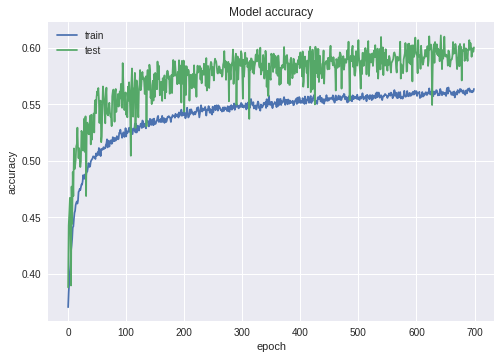

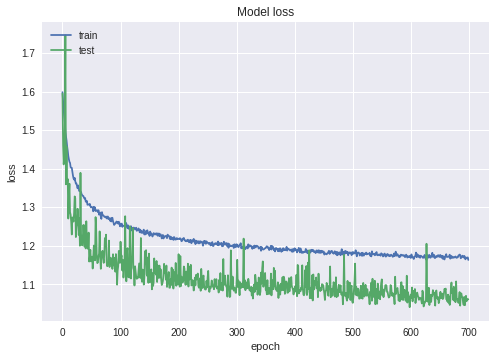

Loaded model from disk
Prediction Started
             precision    recall  f1-score   support

      Angry       0.50      0.55      0.53       491
    Disgust       0.50      0.04      0.07        55
       Fear       0.51      0.23      0.31       528
      Happy       0.85      0.88      0.87       879
        Sad       0.45      0.50      0.47       594
   Surprise       0.75      0.71      0.73       416
    Neutral       0.53      0.73      0.61       626

avg / total       0.61      0.62      0.60      3589

Confusion matrix, without normalization
[[269   1  26  21  89   9  76]
 [ 32   2   6   3   6   3   3]
 [105   1 120  22 141  59  80]
 [ 17   0   7 774  23  16  42]
 [ 58   0  22  34 297   5 178]
 [ 21   0  44  25  11 295  20]
 [ 31   0  10  31  93   7 454]]


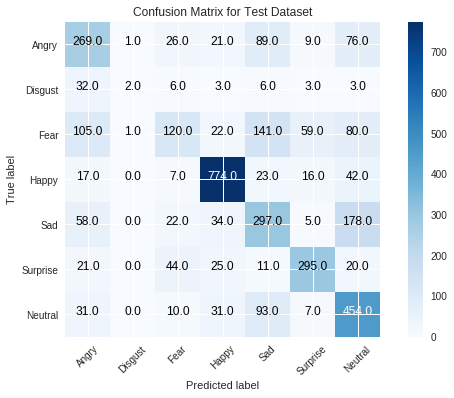

Prediction Finished


In [17]:
# save best weights
checkpointer = ModelCheckpoint(filepath='drive/app/face_model.h5', verbose=1, save_best_only=True)
epochs = 700
hist=model.fit_generator(datagen.flow(x_train, y_train, batch_size = 100),
                    steps_per_epoch = len(x_train) / 100, # number of samples per gradient update
                    epochs = epochs, # number of iterations
                    validation_data= (x_test, y_test),
                    callbacks=[checkpointer],
                    verbose=1)
# save model to json
model_json = model.to_json()
with open("drive/app/face_model.json", "w") as json_file:
    json_file.write(model_json)
    
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape
score = model.evaluate(x_test_private, y_test_private, verbose=0)
score
    
print(hist.history.keys())
# summarize by plotting graph history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
	
	
# summarize by plotting graph history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

cnn = load_model('drive/app/face_model.h5')
print("Loaded model from disk")
print("Prediction Started")


     
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
    print(cm)
            
            
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
        
        
  #Predict the features label   
Y_pred_private = cnn.predict(x_test_private, batch_size=512, verbose=0)
y_pred_private = np.argmax(Y_pred_private, axis=1)
target_names = ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
     
#print classification report
print(classification_report(np.argmax(y_test_private,axis=1), y_pred_private,target_names=target_names))
     
     
#calculate confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(y_test_private,axis=1),y_pred_private)
     
#plot confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=False,
                      title='Confusion Matrix for Test Dataset')
plt.show()
print("Prediction Finished")

        


  

In [18]:
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape
score = model.evaluate(x_test_private, y_test_private, verbose=0)
score

[1.0141558106412594, 0.6157704096180577]